In [1]:
import pandas as pd
import numpy as np

In [2]:
faults = pd.read_csv("../data/J1939Faults.csv")
diagnostics = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")
# faults = faults[(faults['Latitude'] != 36.0666667) & (faults['Longitude'] != -86.4347222)]
# faults = faults[(faults['Latitude'] != 35.5883333) & (faults['Longitude'] != -86.4438888)]
# faults = faults[(faults['Latitude'] != 36.1950) & (faults['Longitude'] != -83.174722)]

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_24816/3395871266.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  faults = pd.read_csv("../data/J1939Faults.csv")


In [3]:
diagnostics.head()

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


In [4]:
diag_pivot = diagnostics.pivot(index='FaultId', columns='Name', values='Value').reset_index()

In [5]:
diag_pivot

Name,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,0,14.21,False,66.48672,423178.7,100.4,11,0,96.74375,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1187331,1248455,100,14.5,True,64.6226,423937.9,185,51,37.12,211.4937,...,32,True,98.6,18431,False,NaN,65.01096,NaN,73.2,7.83
1187332,1248456,0,14.355,True,66.48672,465925.4,186.8,62,41.18,212.8438,...,NaN,True,91.4,17407,NaN,NaN,66.5741,NaN,100,6.96
1187333,1248457,1.6,14.4275,False,67.72946,28606.65625,181.4,0,27.26,221.7312,...,NaN,True,100.4,1023,False,NaN,11.84489,14.1,100,1.74


In [6]:
faults_diagnostics_merged = pd.merge(faults, diag_pivot, how='left', left_on='RecordID', right_on='FaultId')

In [7]:
exclude_coords = [
    (36.0666667, -86.4347222),
    (35.5883333, -86.4438888),
    (36.1950, -83.174722)
]
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.7  # Radius of Earth in km - roughly 3958.7 miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2 # this is the haversine formula that's accounting for the curvature of the earth. think calculus & a polar coordinate system.
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) # we're calculating the central angle between the two points
    return R * c # calculates the arc length (distance) we're multiplying the radius of earth and the central angle
threshold = 0.5  # Distance in km - this is roughly about 3.1 miles
distances = np.array([
    haversine(faults_diagnostics_merged['Latitude'], faults_diagnostics_merged['Longitude'], lat, lon)
    for lat, lon in exclude_coords
]) # I'm calculating the difference between the excluded coordinates and geo coordinate in my dataframe. the array is contains the distances as scalar quantities (floats).
# which rows are outside all vicinities
outside_vicinity = (distances > threshold).all(axis=0) # boolean array true if its outside vicinity
faults_diagnostics_merged = faults_diagnostics_merged[outside_vicinity]
faults_diagnostics_merged

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,...,32,True,98.6,18431,False,NaN,65.01096,NaN,73.2,7.83
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,...,NaN,True,91.4,17407,NaN,NaN,66.5741,NaN,100,6.96
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,...,NaN,True,100.4,1023,False,NaN,11.84489,14.1,100,1.74


In [8]:
faults_diagnostics_merged.to_csv("../data/MergedData.csv")

In [9]:
faults_diagnostics_merged_ExaminingByTruck = faults_diagnostics_merged

In [10]:
faults    #.head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000


In [11]:
full_derate = faults[faults['spn'] == 5246]
full_derate 
   #.head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
45,46,990931,2015-02-21 12:10:51.000,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,True,1,NaN,1395,105349612,36.065972,-86.433425,2015-02-21 12:11:27.000
1918,1919,1007751,2015-02-22 19:44:55.000,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,True,1,NaN,1395,105349612,36.066203,-86.434814,2015-02-22 19:46:27.000
2058,2059,1010486,2015-02-23 04:00:21.000,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,False,1,NaN,1395,105349612,36.066666,-86.434537,2015-02-23 01:06:06.000
2089,2090,1011009,2015-02-23 05:05:44.000,NaN,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,1630,105329900,40.733009,-74.087777,2015-02-23 05:08:23.000
2971,2972,1026305,2015-02-23 15:54:22.000,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,NaN,1487,105369355,28.077361,-81.897083,2015-02-23 15:54:58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183032,1244156,121610128,2020-02-19 07:02:33.000,NaN,NaN,05317106*05005224*051718172255*09401583*G1*BDR*,79845785,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,1814,105369518,36.067037,-86.434120,2020-02-19 07:03:09.000
1183684,1244808,121909497,2020-02-21 07:23:44.000,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,16,True,1,NaN,2211,105329862,36.066296,-86.434305,2020-02-21 07:24:20.000
1184328,1245452,122305094,2020-02-24 15:28:05.000,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,16,False,1,NaN,2211,105329862,36.066620,-86.434722,2020-02-24 15:28:01.000
1184330,1245454,122305096,2020-02-24 15:27:26.000,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,0,True,1,NaN,2211,105329862,36.066620,-86.434722,2020-02-24 15:28:02.000


In [12]:
faults_diagnostic_merged_FullDerate = faults_diagnostics_merged[faults_diagnostics_merged['spn'] == 5246]
faults_diagnostic_merged_FullDerate

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
2089,2090,1011009,2015-02-23 05:05:44.000,NaN,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,NaN,False,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
2971,2972,1026305,2015-02-23 15:54:22.000,NaN,NaN,unknown,unknown,unknown,unknown,0,...,NaN,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
5713,5714,1070646,2015-02-25 13:53:08.000,NaN,NaN,unknown,unknown,unknown,unknown,0,...,NaN,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
5809,5810,1071907,2015-02-25 14:47:00.000,NaN,NaN,unknown,unknown,unknown,unknown,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
6534,6535,1097942,2015-02-26 22:24:29.000,NaN,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,140,22527,NaN,NaN,0,3276.75,NaN,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179423,1239564,119961467,2020-02-06 08:03:09.000,NaN,NaN,04358814*06005963*051718174436*09401683*G1*BDR*,79897320,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
1181700,1241841,120905759,2020-02-13 13:32:39.000,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,0,...,NaN,True,120.2,22527,True,NaN,0,NaN,100,0.58
1181717,1241858,120910417,2020-02-13 14:01:40.000,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1181996,1242137,121038018,2020-02-14 11:21:54.000,NaN,NaN,NaN,NaN,NaN,NaN,49,...,19.4,True,26.6,255,True,NaN,0,NaN,0,0.58


In [13]:
faults[faults['spn'] == 5246]['fmi'].value_counts()

fmi
0     790
16    171
15    113
19     99
14     22
Name: count, dtype: int64

In [14]:
faults_diagnostics_merged[faults['spn'] == 5246]['fmi'].value_counts()

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_24816/4217609497.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  faults_diagnostics_merged[faults['spn'] == 5246]['fmi'].value_counts()


fmi
0     621
16    143
15    103
19     61
14      8
Name: count, dtype: int64

In [15]:
faults[faults['spn'] == 5246] # .head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
45,46,990931,2015-02-21 12:10:51.000,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,True,1,NaN,1395,105349612,36.065972,-86.433425,2015-02-21 12:11:27.000
1918,1919,1007751,2015-02-22 19:44:55.000,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,True,1,NaN,1395,105349612,36.066203,-86.434814,2015-02-22 19:46:27.000
2058,2059,1010486,2015-02-23 04:00:21.000,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,False,1,NaN,1395,105349612,36.066666,-86.434537,2015-02-23 01:06:06.000
2089,2090,1011009,2015-02-23 05:05:44.000,NaN,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,1630,105329900,40.733009,-74.087777,2015-02-23 05:08:23.000
2971,2972,1026305,2015-02-23 15:54:22.000,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,NaN,1487,105369355,28.077361,-81.897083,2015-02-23 15:54:58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183032,1244156,121610128,2020-02-19 07:02:33.000,NaN,NaN,05317106*05005224*051718172255*09401583*G1*BDR*,79845785,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,1814,105369518,36.067037,-86.434120,2020-02-19 07:03:09.000
1183684,1244808,121909497,2020-02-21 07:23:44.000,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,16,True,1,NaN,2211,105329862,36.066296,-86.434305,2020-02-21 07:24:20.000
1184328,1245452,122305094,2020-02-24 15:28:05.000,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,16,False,1,NaN,2211,105329862,36.066620,-86.434722,2020-02-24 15:28:01.000
1184330,1245454,122305096,2020-02-24 15:27:26.000,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,0,True,1,NaN,2211,105329862,36.066620,-86.434722,2020-02-24 15:28:02.000


In [16]:
faults_diagnostics_merged[faults_diagnostics_merged['spn'] == 5246] # .head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
2089,2090,1011009,2015-02-23 05:05:44.000,NaN,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,NaN,False,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
2971,2972,1026305,2015-02-23 15:54:22.000,NaN,NaN,unknown,unknown,unknown,unknown,0,...,NaN,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
5713,5714,1070646,2015-02-25 13:53:08.000,NaN,NaN,unknown,unknown,unknown,unknown,0,...,NaN,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
5809,5810,1071907,2015-02-25 14:47:00.000,NaN,NaN,unknown,unknown,unknown,unknown,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
6534,6535,1097942,2015-02-26 22:24:29.000,NaN,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,140,22527,NaN,NaN,0,3276.75,NaN,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179423,1239564,119961467,2020-02-06 08:03:09.000,NaN,NaN,04358814*06005963*051718174436*09401683*G1*BDR*,79897320,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
1181700,1241841,120905759,2020-02-13 13:32:39.000,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,0,...,NaN,True,120.2,22527,True,NaN,0,NaN,100,0.58
1181717,1241858,120910417,2020-02-13 14:01:40.000,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1181996,1242137,121038018,2020-02-14 11:21:54.000,NaN,NaN,NaN,NaN,NaN,NaN,49,...,19.4,True,26.6,255,True,NaN,0,NaN,0,0.58


## Exploring individual truck's data: 

In [17]:
Truck_1419 = faults_diagnostics_merged_ExaminingByTruck[(faults_diagnostics_merged_ExaminingByTruck['EquipmentID'] == 1419) & (faults_diagnostics_merged_ExaminingByTruck['EventTimeStamp'] > "2016-03-20 00:00:00")]
Truck_1419

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
420823,429090,8259844,2016-03-27 15:52:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,95,1023,NaN,NaN,11.45653,NaN,NaN,9.28
420893,429160,8261624,2016-03-27 19:52:10.000,Low (Severity Low) Catalyst Tank Level,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
436676,444943,8570192,2016-04-12 12:04:56.000,Low (Severity Low) Catalyst Tank Level,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,95,1023,NaN,NaN,62.15654,NaN,NaN,24.94
436812,445079,8572881,2016-04-12 13:54:14.000,Low (Severity Low) Catalyst Tank Level,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
441415,449682,8660464,2016-04-16 13:51:33.000,High (Severity Low) Particulate Trap 1 Ash Loa...,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,113,1023,NaN,NaN,60.71962,NaN,NaN,2.9
449001,458118,8805903,2016-04-24 15:20:40.000,NaN,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,125.6,17407,NaN,NaN,0,NaN,NaN,2.9
449022,458139,8806281,2016-04-24 16:00:43.000,Condition Exists Catalyst Dosing Unit Input Lines,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,118.4,17407,NaN,NaN,61.83614,NaN,NaN,27.84
449049,458166,8806652,2016-04-24 16:36:26.000,Condition Exists Engine Protection Torque Derate,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,120.2,18431,NaN,NaN,64.85562,NaN,NaN,11.6
449131,458248,8808999,2016-04-24 22:50:49.000,NaN,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,True,131,22527,NaN,NaN,0,NaN,NaN,0
449942,459059,8825482,2016-04-25 16:00:44.000,NaN,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
Truck_1486 = faults_diagnostics_merged_ExaminingByTruck[(faults_diagnostics_merged_ExaminingByTruck['EquipmentID'] == 1486) & (faults_diagnostics_merged_ExaminingByTruck['EventTimeStamp'] < "2015-04-01 00:00:00")]
Truck_1486

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure


In [19]:
Truck_1492 = faults_diagnostics_merged_ExaminingByTruck[(faults_diagnostics_merged_ExaminingByTruck['EquipmentID'] == 1492) & (faults_diagnostics_merged_ExaminingByTruck['EventTimeStamp'] < "2015-06-01 00:00:00")]
Truck_1492

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
66150,68220,2649100,2015-05-28 00:54:00.000,Low (Severity Medium) Engine Coolant Level,NaN,04993120*00063987*082113134117*07700053*I0*BBZ*,79488008,6X1u10D1500000000,CMMNS,0,...,NaN,True,123.8,2047,NaN,NaN,0,3276.75,NaN,1.74
67196,69266,2667591,2015-05-28 18:14:02.000,Condition Exists Engine Coolant Temperature,NaN,04993120*00063987*082113134117*07700053*I0*BBZ*,79488008,6X1u10D1500000000,CMMNS,0,...,NaN,True,104,2047,NaN,NaN,51.49614,3276.75,NaN,2.03
67202,69272,2667684,2015-05-28 18:20:40.000,Condition Exists Engine Coolant Temperature,NaN,04993120*00063987*082113134117*07700053*I0*BBZ*,79488008,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,2047,NaN,NaN,NaN,NaN,NaN,NaN
67348,69418,2670101,2015-05-28 22:27:20.000,Low (Severity Medium) Engine Coolant Level,NaN,04993120*00063987*082113134117*07700053*I0*BBZ*,79488008,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
67350,69420,2670105,2015-05-28 22:27:47.000,Low (Severity Medium) Engine Coolant Level,NaN,04993120*00063987*082113134117*07700053*I0*BBZ*,79488008,6X1u10D1500000000,CMMNS,0,...,NaN,True,100.4,2047,NaN,NaN,13.86434,3276.75,NaN,8.99


In [20]:
Truck_1473 = faults_diagnostics_merged[(faults_diagnostics_merged['EquipmentID'] == 1473) & (faults_diagnostics_merged['EventTimeStamp'] < "2015-05-01 00:00:00")]
Truck_1473

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
36745,37857,2153935,2015-04-29 11:24:12.000,Low (Severity Medium) Engine Injector Metering...,NaN,unknown,unknown,unknown,unknown,0,...,NaN,True,95,17407,NaN,NaN,63.82647,3276.75,NaN,15.95
36899,38011,2157222,2015-04-29 13:25:50.000,Low (Severity Medium) Engine Injector Metering...,NaN,unknown,unknown,unknown,unknown,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
38352,39464,2185786,2015-04-30 17:28:19.000,Low (Severity Medium) Engine Injector Metering...,NaN,unknown,unknown,unknown,unknown,0,...,NaN,True,100.4,17407,NaN,NaN,65.66146,3276.75,NaN,14.5


In [21]:
Truck_1630 = faults_diagnostics_merged[(faults_diagnostics_merged['EquipmentID'] == 1630) & (faults_diagnostics_merged['EventTimeStamp'] > "2017-09-20 00:00:00") & (faults_diagnostics_merged['EventTimeStamp'] < "2017-10-10 00:00:00")]
Truck_1630

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
851692,874958,26980100,2017-09-20 00:02:43.000,Low (Severity Low) Catalyst Tank Level,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
851693,874959,26980101,2017-09-20 00:02:43.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN
851699,874965,26981166,2017-09-20 00:02:51.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,120.2,1279,False,NaN,10.34,NaN,100,7.25
852195,875461,27036241,2017-09-20 11:34:03.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,104,1279,True,NaN,0,NaN,100,0
852369,875635,27055818,2017-09-20 14:39:18.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,132.8,1279,True,NaN,0,NaN,100,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864381,887647,28823411,2017-10-09 14:30:56.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864385,887651,28824610,2017-10-09 14:44:57.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864387,887653,28824785,2017-10-09 14:46:24.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864392,887658,28825488,2017-10-09 14:26:16.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,77,1279,True,NaN,0,NaN,100,0


In [22]:
Truck_1339 = faults_diagnostics_merged[(faults_diagnostics_merged['EquipmentID'] == 1630) & (faults_diagnostics_merged['EventTimeStamp'] > "2017-09-20 00:00:00") & (faults_diagnostics_merged['EventTimeStamp'] < "2017-10-10 00:00:00")]
Truck_1339

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
851692,874958,26980100,2017-09-20 00:02:43.000,Low (Severity Low) Catalyst Tank Level,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
851693,874959,26980101,2017-09-20 00:02:43.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN
851699,874965,26981166,2017-09-20 00:02:51.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,120.2,1279,False,NaN,10.34,NaN,100,7.25
852195,875461,27036241,2017-09-20 11:34:03.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,104,1279,True,NaN,0,NaN,100,0
852369,875635,27055818,2017-09-20 14:39:18.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,132.8,1279,True,NaN,0,NaN,100,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864381,887647,28823411,2017-10-09 14:30:56.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864385,887651,28824610,2017-10-09 14:44:57.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864387,887653,28824785,2017-10-09 14:46:24.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864392,887658,28825488,2017-10-09 14:26:16.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,77,1279,True,NaN,0,NaN,100,0


In [23]:
Truck_1630q = faults_diagnostics_merged.query('EquipmentID == 1630 and EventTimeStamp > "2017-09-20 00:00:00" and EventTimeStamp < "2017-10-10 00:00:00"') 
Truck_1630q

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
851692,874958,26980100,2017-09-20 00:02:43.000,Low (Severity Low) Catalyst Tank Level,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
851693,874959,26980101,2017-09-20 00:02:43.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN
851699,874965,26981166,2017-09-20 00:02:51.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,120.2,1279,False,NaN,10.34,NaN,100,7.25
852195,875461,27036241,2017-09-20 11:34:03.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,104,1279,True,NaN,0,NaN,100,0
852369,875635,27055818,2017-09-20 14:39:18.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,132.8,1279,True,NaN,0,NaN,100,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864381,887647,28823411,2017-10-09 14:30:56.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864385,887651,28824610,2017-10-09 14:44:57.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864387,887653,28824785,2017-10-09 14:46:24.000,NaN,NaN,05290170*03015749*020516150530*09400053*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,...,32,True,77,17407,True,NaN,0,NaN,100,0
864392,887658,28825488,2017-10-09 14:26:16.000,Abnormal Update Rate Tire Location,NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,32,True,77,1279,True,NaN,0,NaN,100,0


In [24]:
Truck_1383_Before2015May = faults_diagnostics_merged.query('EquipmentID == 1383 and EventTimeStamp < "2015-05-01 00:00:00"') 
Truck_1383_Before2015May

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
33106,34218,2089797,2015-04-25 15:55:01.000,Low Voltage (Aftertreatment 1 Intake NOx),NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,75.2,17407,NaN,NaN,59.53513,3276.75,NaN,1.16
33151,34263,2090569,2015-04-25 17:50:17.000,Not Reporting Data Aftertreatment 1 Fuel Enabl...,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,91.4,17407,NaN,NaN,45.88438,3276.75,NaN,27.84
33174,34286,2091011,2015-04-25 18:53:52.000,Abnormal Update Rate Aftertreatment 1 Intake NOx,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,64.4,17407,NaN,NaN,5.427289,3276.75,NaN,2.32
33243,34355,2091559,2015-04-25 20:54:27.000,Condition Exists Engine Protection Torque Derate,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,118.4,18431,NaN,NaN,0,3276.75,NaN,14.21
33662,34774,2097445,2015-04-26 15:48:59.000,Abnormal Update Rate Aftertreatment 1 Intake NOx,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,18431,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38514,39626,2189150,2015-04-30 21:59:23.000,Condition Exists Engine Protection Torque Derate,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
38525,39637,2189365,2015-04-30 22:35:39.000,Condition Exists Engine Protection Torque Derate,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,50,18431,NaN,NaN,66.49643,3276.75,NaN,1.74
38526,39638,2189371,2015-04-30 22:37:07.000,Condition Exists Engine Protection Torque Derate,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
38532,39644,2189584,2015-04-30 23:18:34.000,Condition Exists Engine Protection Torque Derate,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,57.2,18431,NaN,NaN,65.94302,3276.75,NaN,1.45


In [25]:
Truck_1383_After2015Oct15 = faults_diagnostics_merged.query('EquipmentID == 1383 and EventTimeStamp > "2015-10-15 00:00:00"') 
Truck_1383_After2015Oct15

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
242360,246180,5258294,2015-10-18 10:34:15.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,48.2,1023,NaN,NaN,0,NaN,NaN,0
242363,246183,5258318,2015-10-18 10:36:35.000,Special Instructions System Diagnostic Code #1,NaN,unknown,unknown,unknown,unknown,11,...,NaN,True,57.2,1279,NaN,NaN,15.50515,NaN,NaN,8.99
242364,246184,5258336,2015-10-18 10:39:41.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
242747,246567,5264678,2015-10-19 01:41:02.000,Low (Severity High) Wheel Sensor ABS Axle 3 Right,NaN,unknown,unknown,unknown,unknown,11,...,NaN,True,59,1279,NaN,NaN,NaN,NaN,NaN,0
242748,246568,5264679,2015-10-19 01:41:02.000,Low Voltage (Power Supply (obsolete)),NaN,unknown,unknown,unknown,unknown,11,...,NaN,True,59,1279,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321709,326766,6551217,2015-12-28 21:50:02.000,Low Voltage (Accelerator Pedal #1 Channel 2),NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,NaN
321710,326767,6551219,2015-12-28 21:50:12.000,High Voltage (Heater Circuit #09),NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,True,86,22527,False,NaN,0,NaN,NaN,0
321711,326768,6551225,2015-12-28 21:51:39.000,High Voltage (Heater Circuit #09),NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,21503,NaN,NaN,NaN,NaN,NaN,NaN
321714,326771,6551238,2015-12-28 21:53:03.000,Low Voltage (Accelerator Pedal Position 1),NaN,04993120*00020603*082113134117*07700053*I0*BBZ*,79463007,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
Truck_1490_Before2015Aug = faults_diagnostics_merged.query('EquipmentID == 1490 and EventTimeStamp < "2015-08-01 00:00:00"') 
Truck_1490_Before2015Aug

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
39378,40490,2204533,2015-05-01 15:18:01.000,NaN,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,True,113,17407,NaN,NaN,60.72932,3276.75,NaN,13.63
39851,40963,2211666,2015-05-02 06:46:44.000,NaN,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
54742,56812,2475232,2015-05-17 16:53:22.000,NaN,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,True,102.2,17407,NaN,NaN,70.50621,3276.75,NaN,1.16
55531,57601,2487690,2015-05-18 13:06:50.000,NaN,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
58293,60363,2533311,2015-05-20 15:00:15.000,NaN,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,True,141.8,17407,NaN,NaN,61.65167,3276.75,NaN,20.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133694,136080,3667276,2015-07-24 20:21:22.000,NaN,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
135209,137595,3685869,2015-07-26 15:43:32.000,Not Reporting Data Engine Injector Cylinder #02,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,True,111.2,17407,NaN,NaN,72.04022,3276.75,NaN,2.03
137226,139612,3704424,2015-07-27 15:39:35.000,Not Reporting Data Engine Injector Cylinder #01,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,True,109.4,17407,NaN,NaN,70.59359,3276.75,NaN,1.45
138462,140848,3722849,2015-07-28 12:35:49.000,Not Reporting Data Engine Injector Cylinder #02,NaN,04993120*00063662*040213150018*07700044*I0*BBZ*,79488009,6X1u10D1500000000,CMMNS,0,...,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
faults_diagnostics_merged['EventTimeStamp'] = pd.to_datetime(faults_diagnostics_merged['EventTimeStamp'])

In [28]:
#faults_diagnostics_merged[faults['spn'] == 5246]['fmi'].value_counts()
Faults_Diagnostic_Merged_GroupedBy_EquipmentID_UniqueSPNcountProp = faults_diagnostics_merged.groupby('EquipmentID')['spn'].value_counts(normalize=True).reset_index(name='UniqueSPNcountProportion')   
Faults_Diagnostic_Merged_GroupedBy_EquipmentID_UniqueSPNcountProp 

,EquipmentID,spn,UniqueSPNcountProportion
0,301,96,0.169811
1,301,829,0.169811
2,301,1668,0.090566
3,301,3821,0.083019
4,301,5396,0.075472
...,...,...,...
21321,310,96,0.032258
21322,310,829,0.032258
21323,R1762,1761,0.666667
21324,R1762,5848,0.333333


In [29]:
Faults_GroupedBy_EquipmentID_UniqueSPNcount  = faults.groupby('EquipmentID')['spn'].value_counts().reset_index()
Faults_GroupedBy_EquipmentID_UniqueSPNcount 

,EquipmentID,spn,count
0,301,96,210
1,301,829,210
2,301,1668,118
3,301,5396,96
4,301,111,94
...,...,...,...
28119,310,96,2
28120,310,829,2
28121,R1762,1761,4
28122,R1762,5848,2


In [30]:
Faults_GroupedBy_EquipmentID_UniqueSPNcount  = faults.groupby('EquipmentID')['spn'].value_counts(normalize = True).reset_index()
Faults_GroupedBy_EquipmentID_UniqueSPNcount 

,EquipmentID,spn,proportion
0,301,96,0.143934
1,301,829,0.143934
2,301,1668,0.080877
3,301,5396,0.065798
4,301,111,0.064428
...,...,...,...
28119,310,96,0.031746
28120,310,829,0.031746
28121,R1762,1761,0.666667
28122,R1762,5848,0.333333


In [31]:

Faults_Diagnostic_Merged_GroupedBy_EquipmentID_SPN5426countProp = faults_diagnostics_merged.groupby('EquipmentID')['spn'].value_counts(normalize=True).reset_index(name='UniqueSPNcountProportion')   
Faults_Diagnostic_Merged_GroupedBy_EquipmentID_SPN5426countProp 

,EquipmentID,spn,UniqueSPNcountProportion
0,301,96,0.169811
1,301,829,0.169811
2,301,1668,0.090566
3,301,3821,0.083019
4,301,5396,0.075472
...,...,...,...
21321,310,96,0.032258
21322,310,829,0.032258
21323,R1762,1761,0.666667
21324,R1762,5848,0.333333


In [32]:
TrucksWith5246SPN = Faults_GroupedBy_EquipmentID_UniqueSPNcount[Faults_GroupedBy_EquipmentID_UniqueSPNcount['spn'] == 5246]
TrucksWith5246SPN

,EquipmentID,spn,proportion
34,301,5246,0.004112
91,302,5246,0.001597
221,304,5246,0.000695
236,305,5246,0.005051
320,306,5246,0.006397
...,...,...,...
26858,1942,5246,0.023077
26884,1946,5246,0.025316
27107,1978,5246,0.020202
28087,305,5246,0.003384


In [33]:
TrucksWithout5246SPN = Faults_GroupedBy_EquipmentID_UniqueSPNcount[Faults_GroupedBy_EquipmentID_UniqueSPNcount['spn'] != 5246]
TrucksWithout5246SPN

,EquipmentID,spn,proportion
0,301,96,0.143934
1,301,829,0.143934
2,301,1668,0.080877
3,301,5396,0.065798
4,301,111,0.064428
...,...,...,...
28119,310,96,0.031746
28120,310,829,0.031746
28121,R1762,1761,0.666667
28122,R1762,5848,0.333333


In [34]:
merge = faults_diagnostics_merged

In [35]:
import matplotlib.pyplot as plt

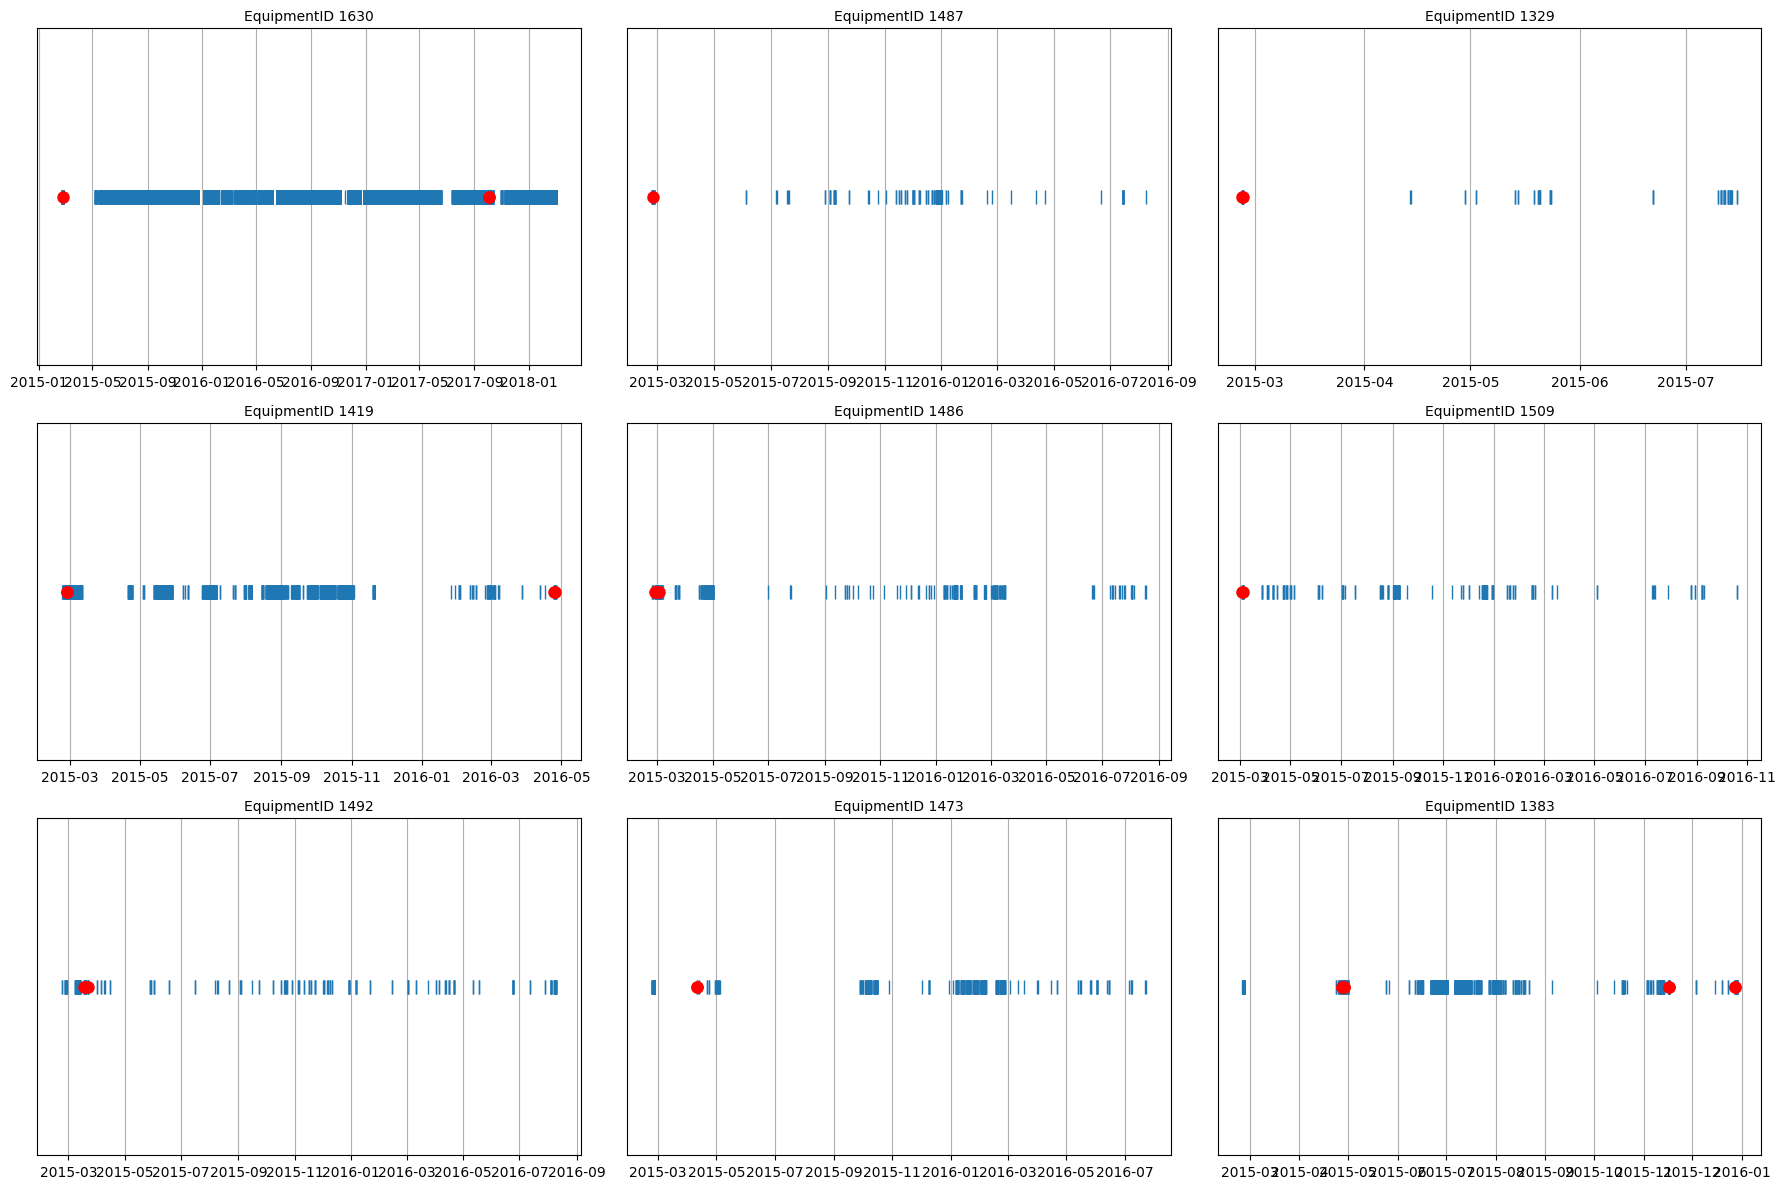

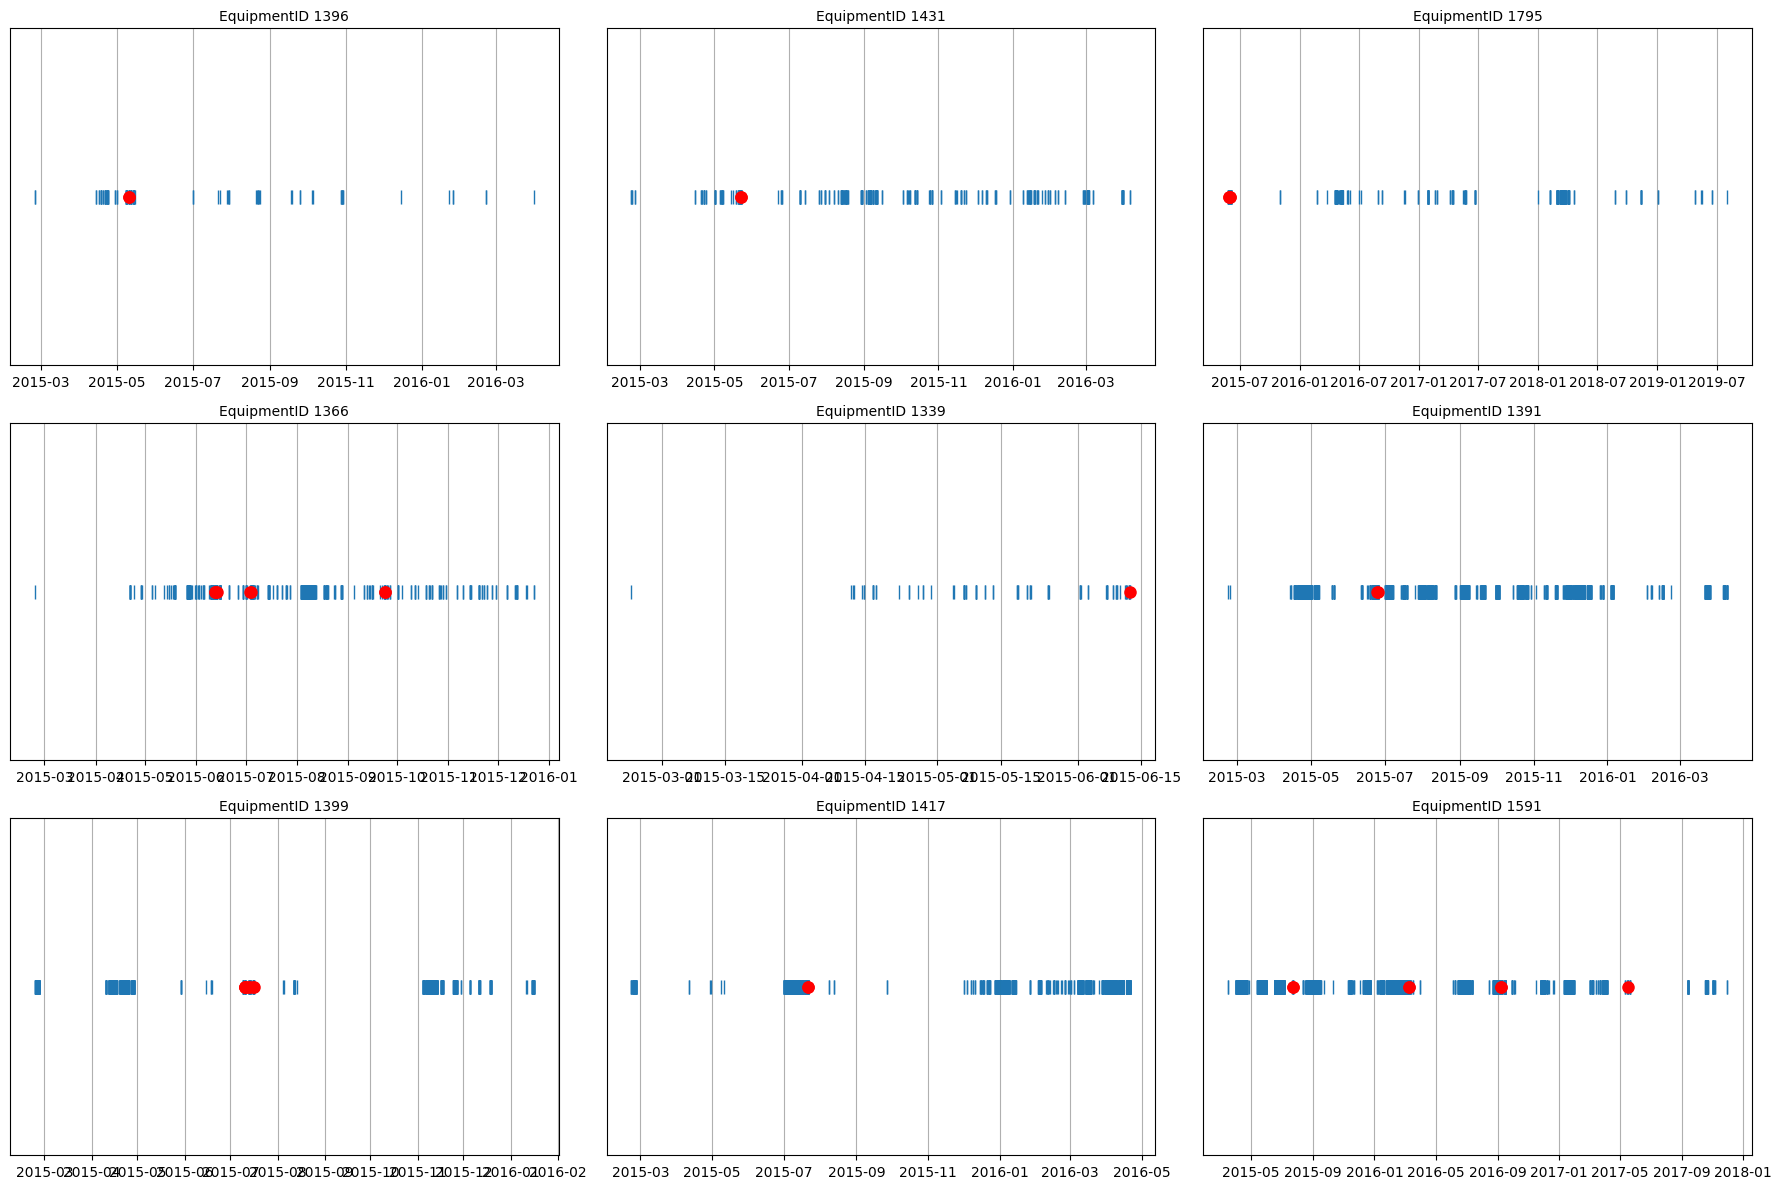

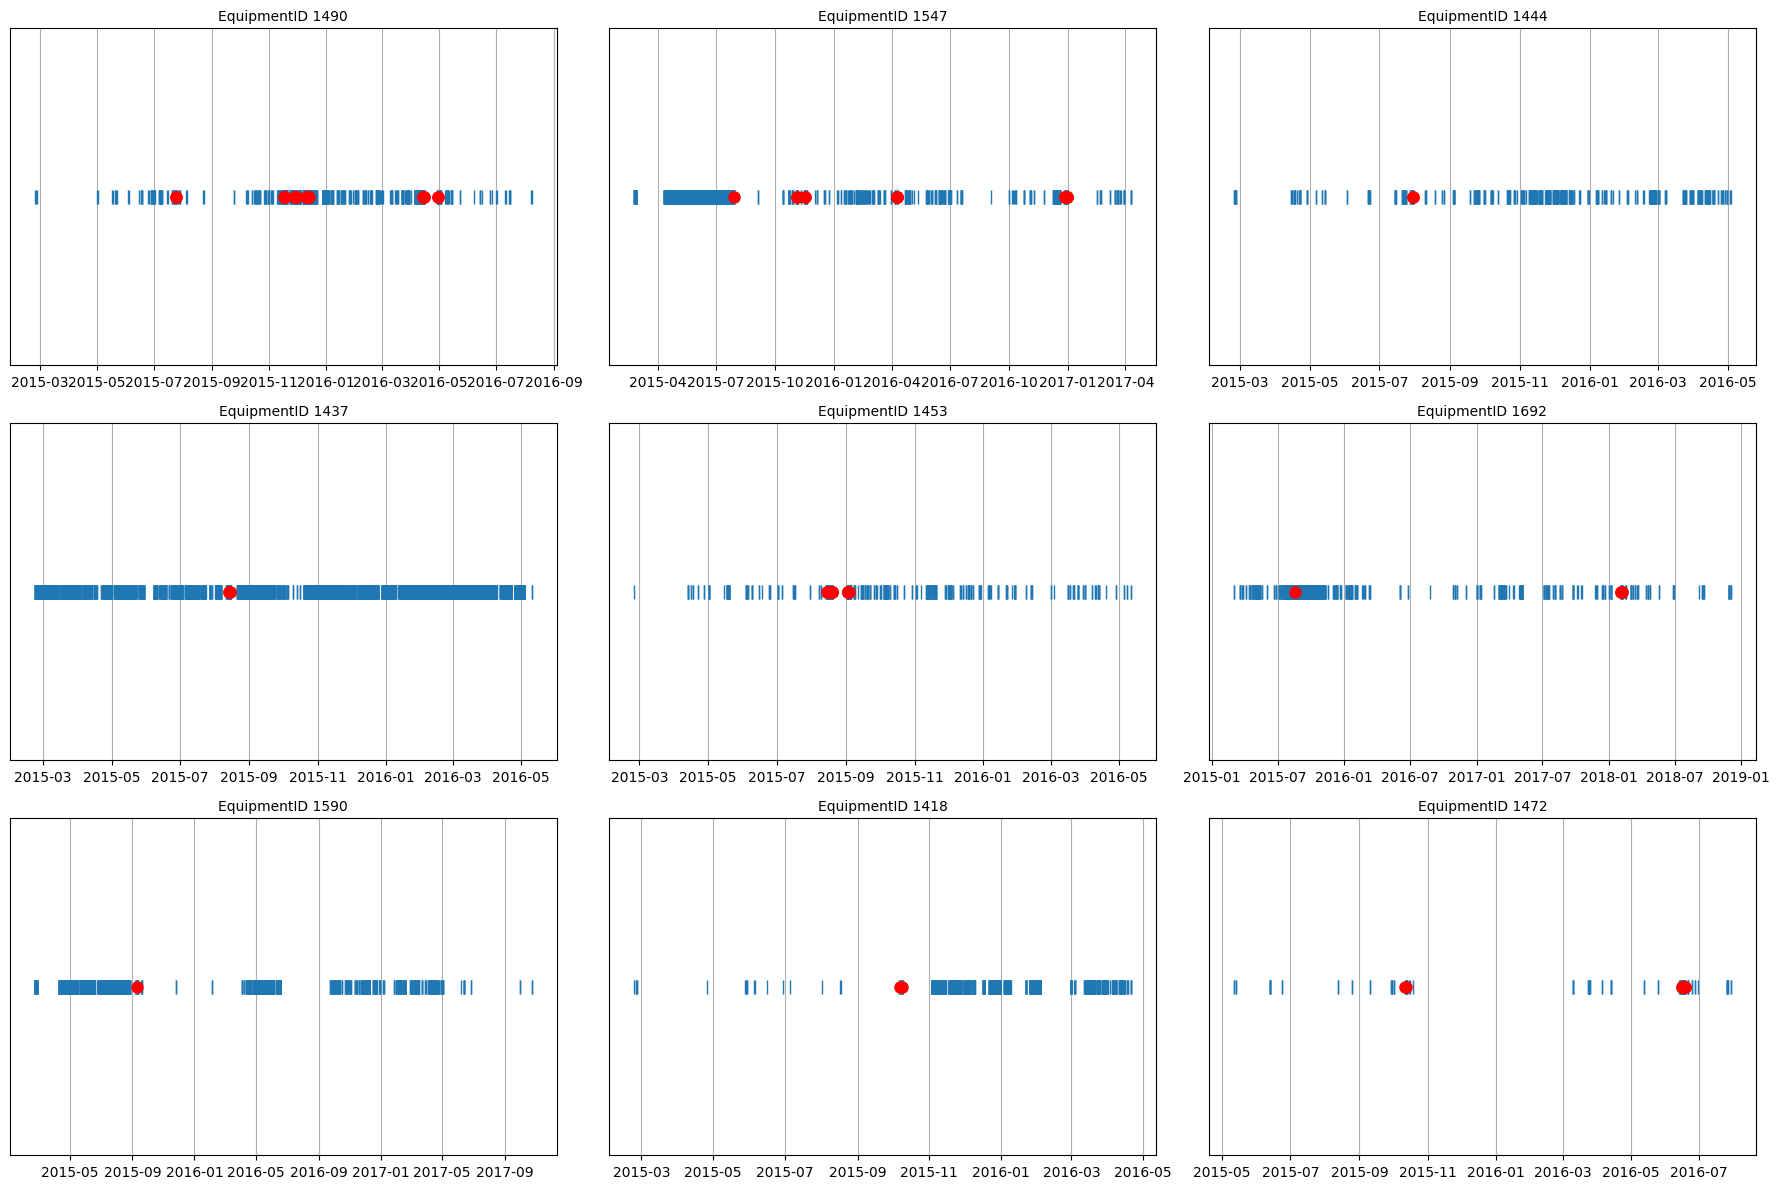

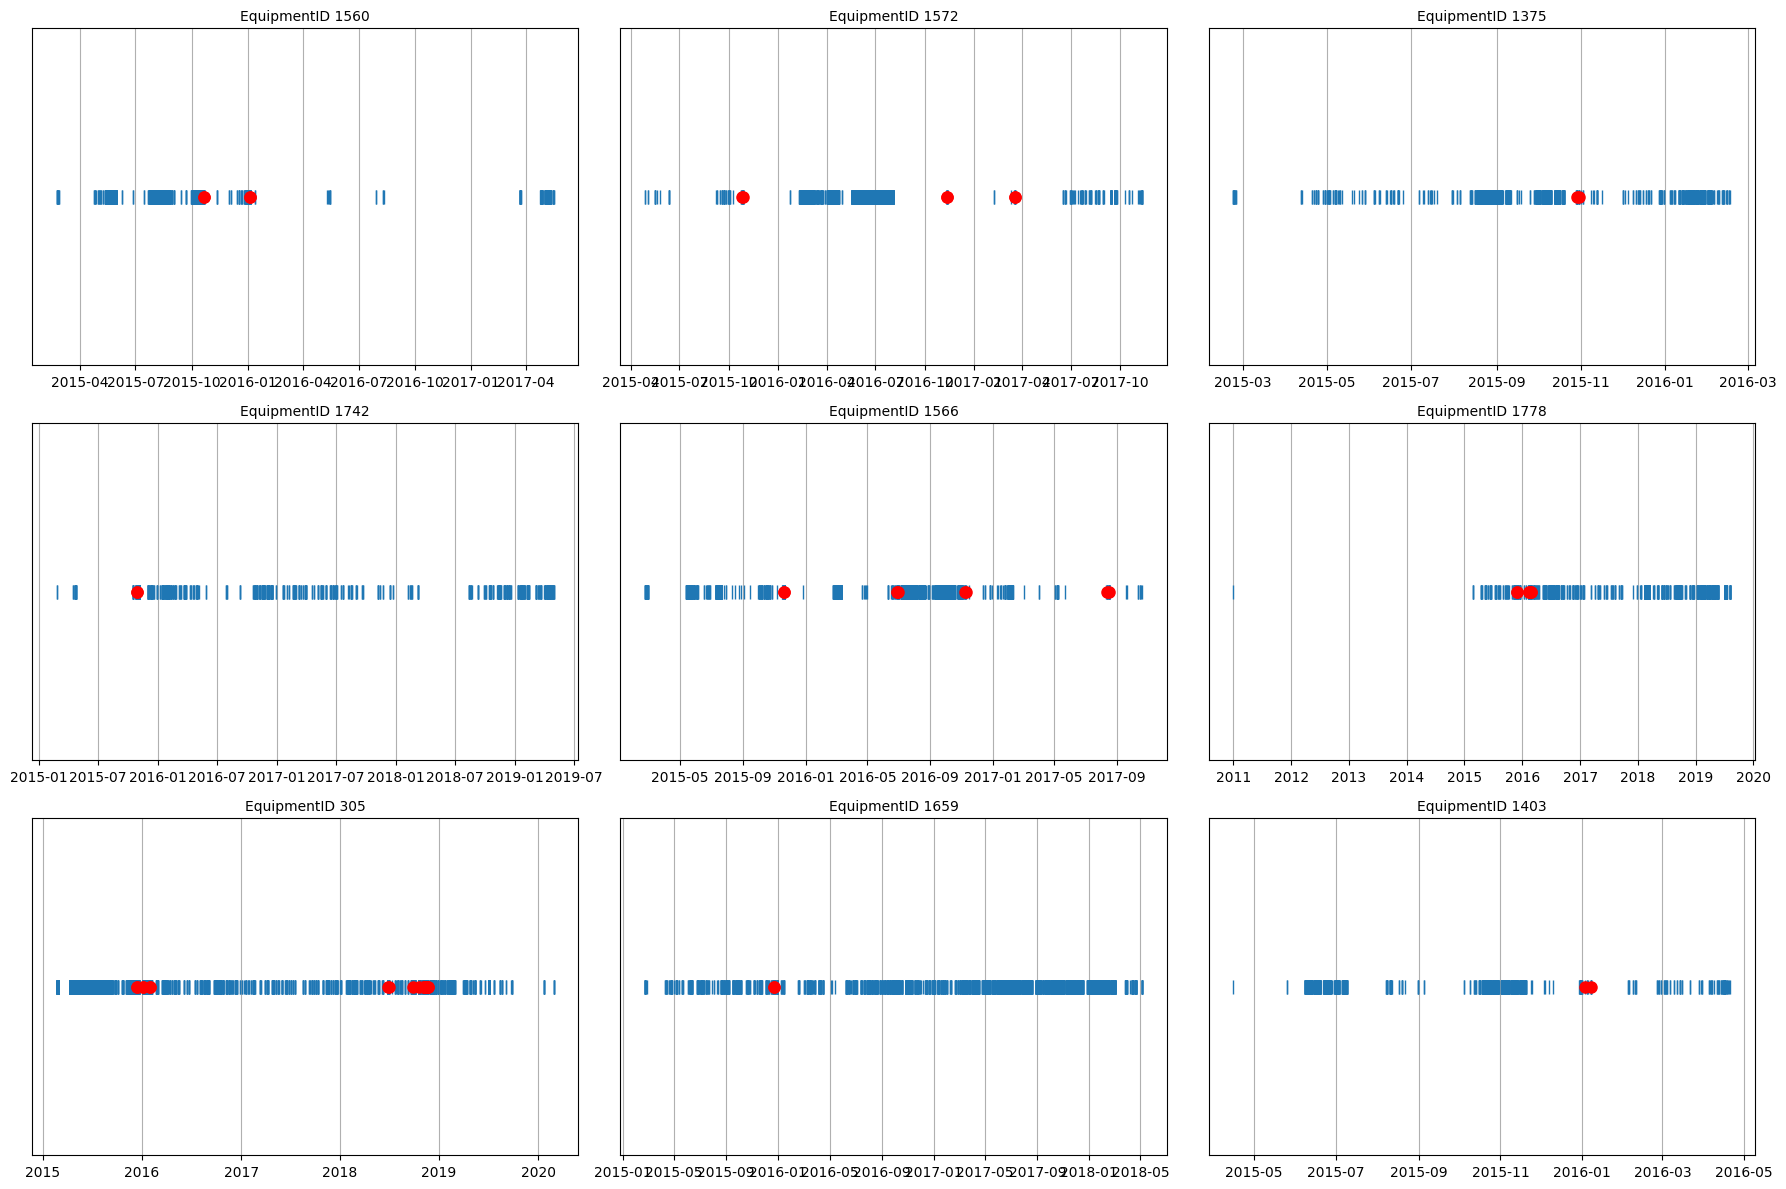

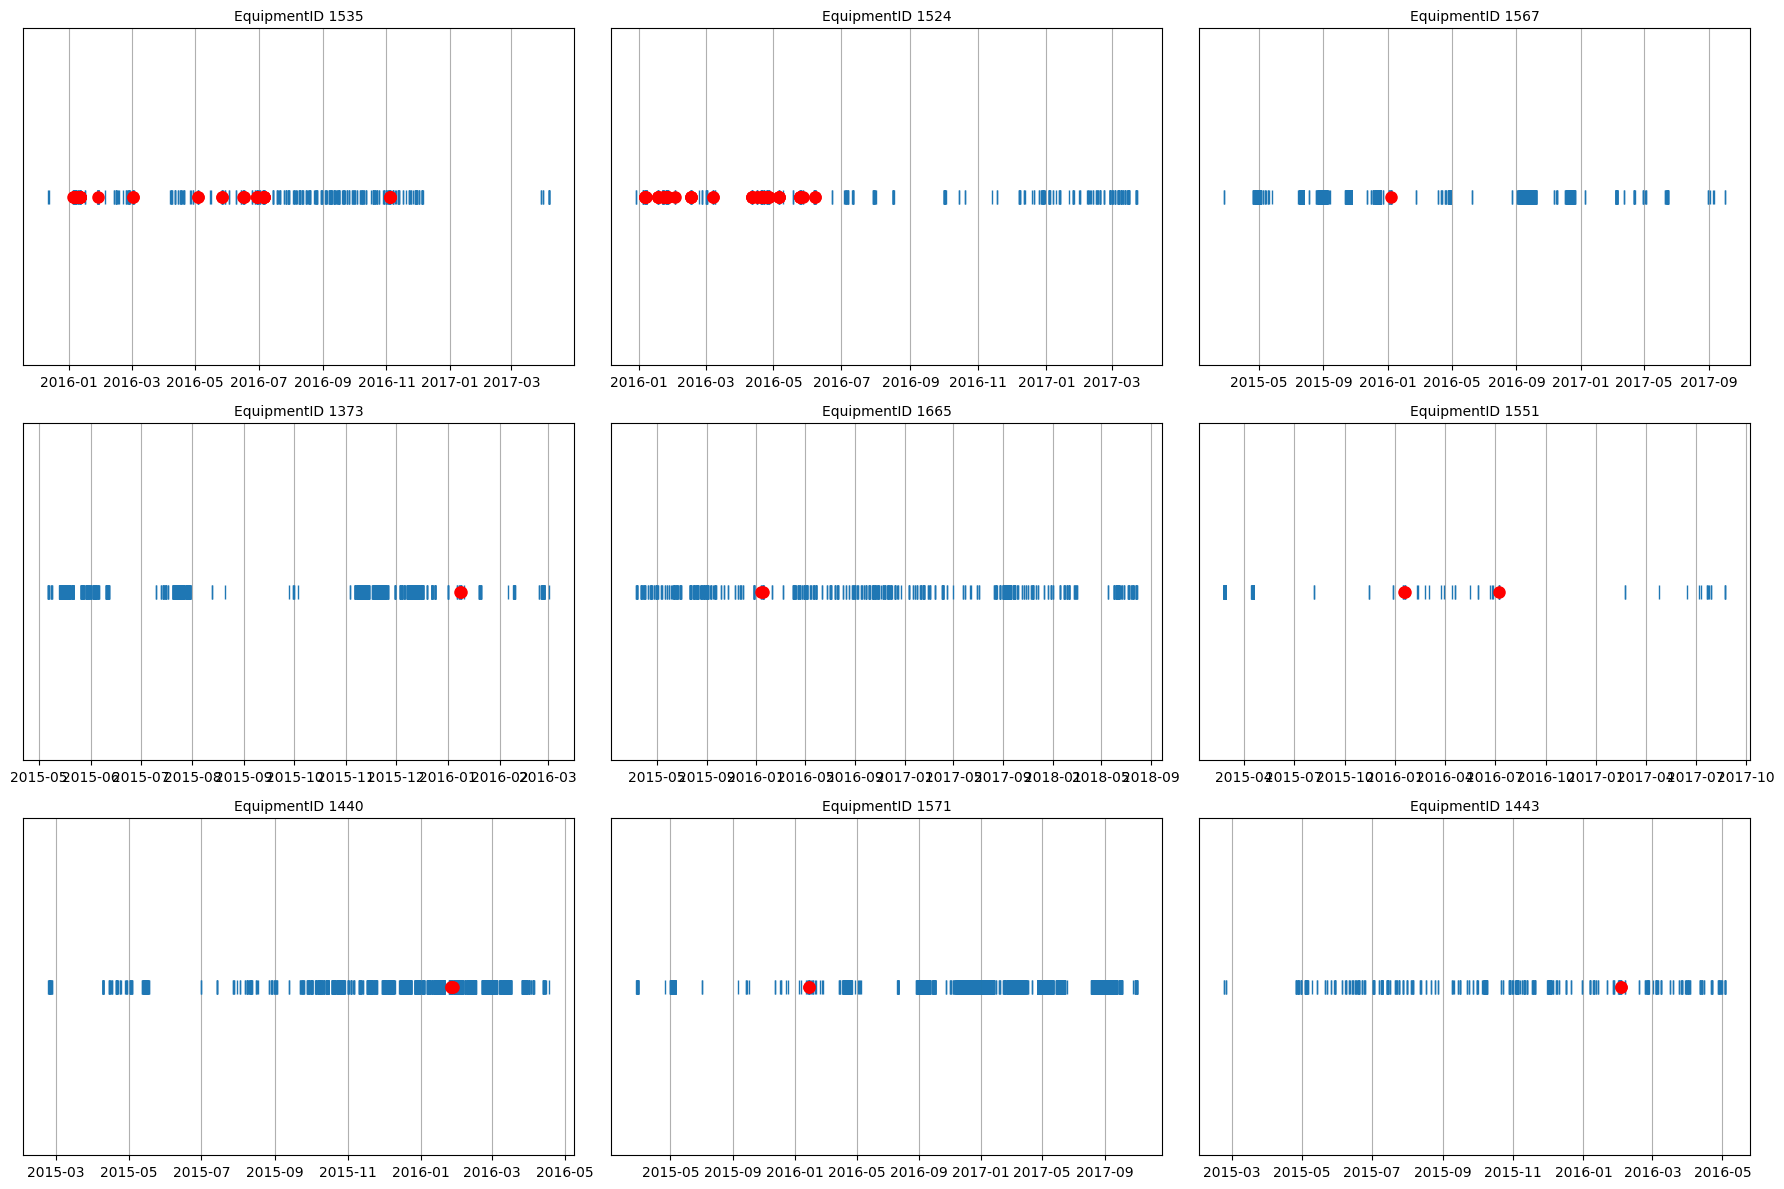

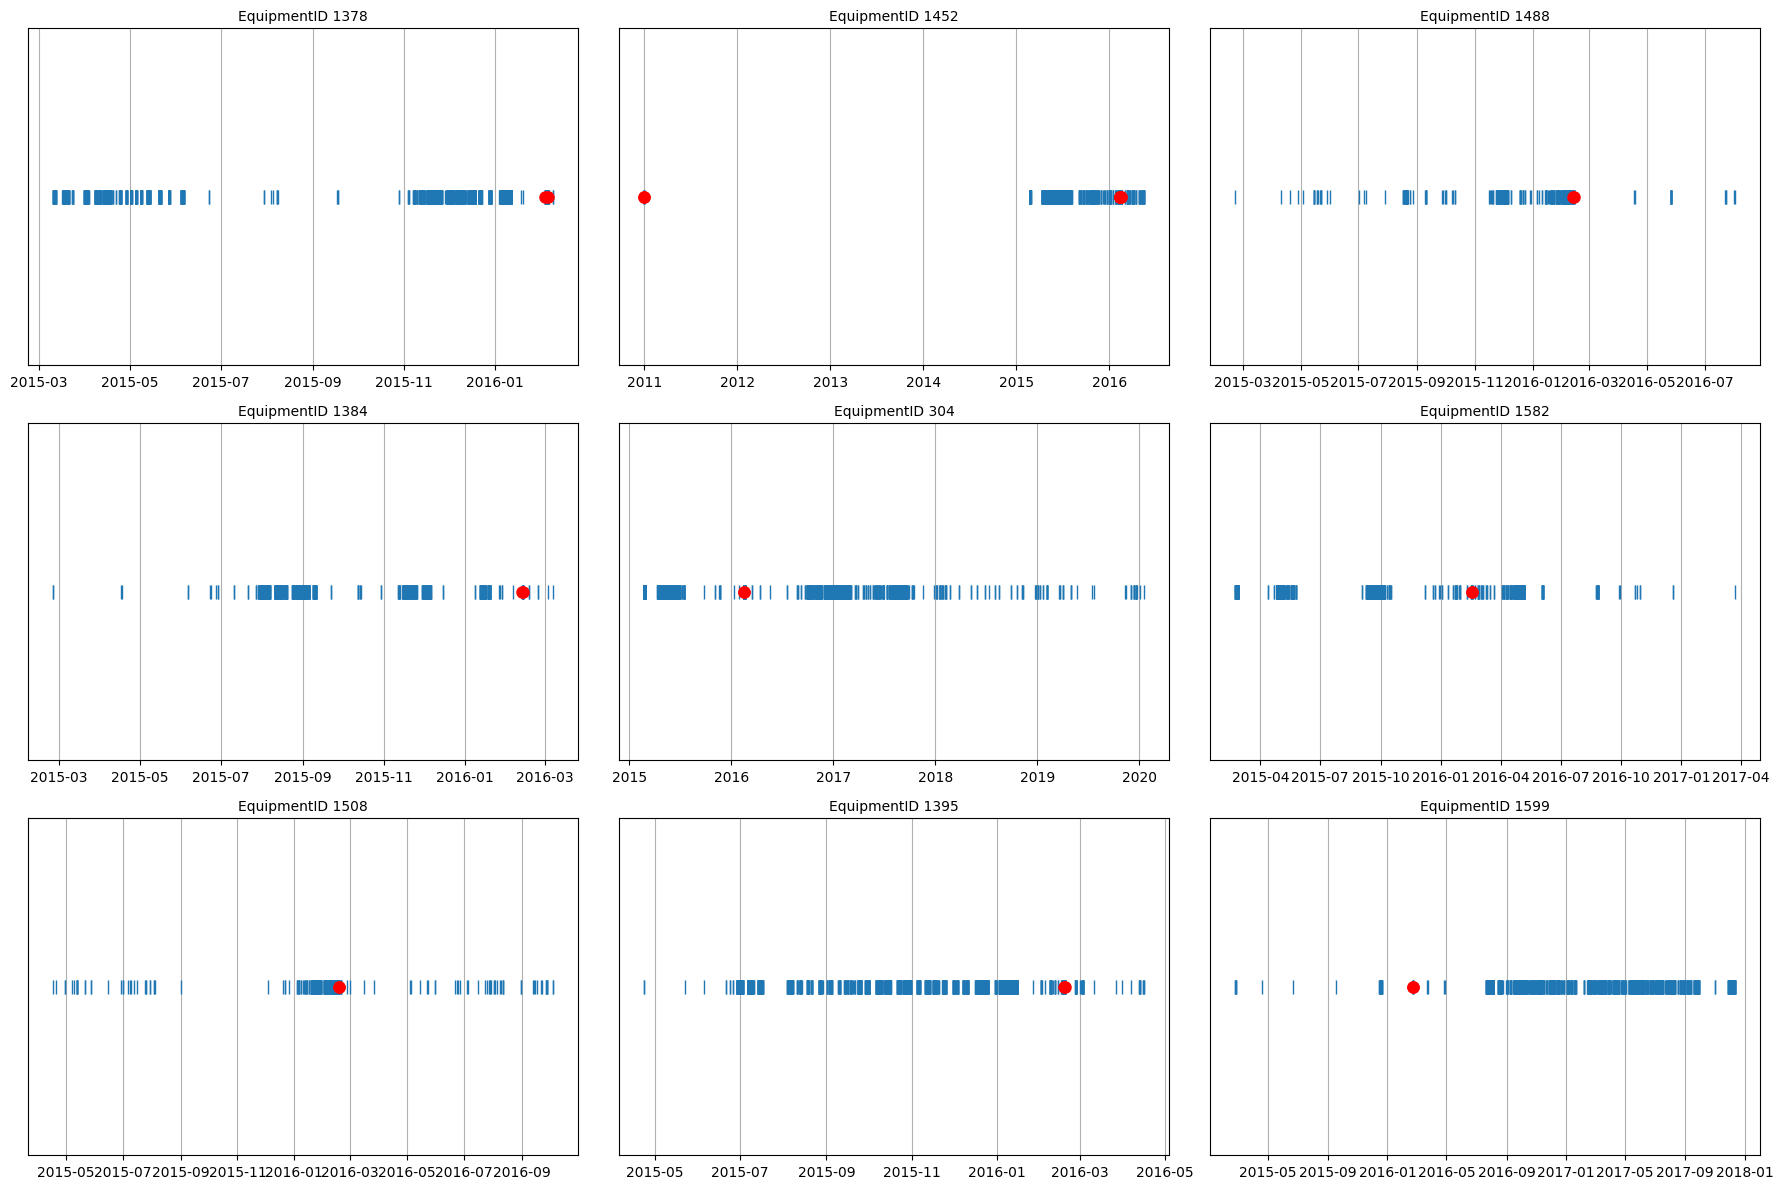

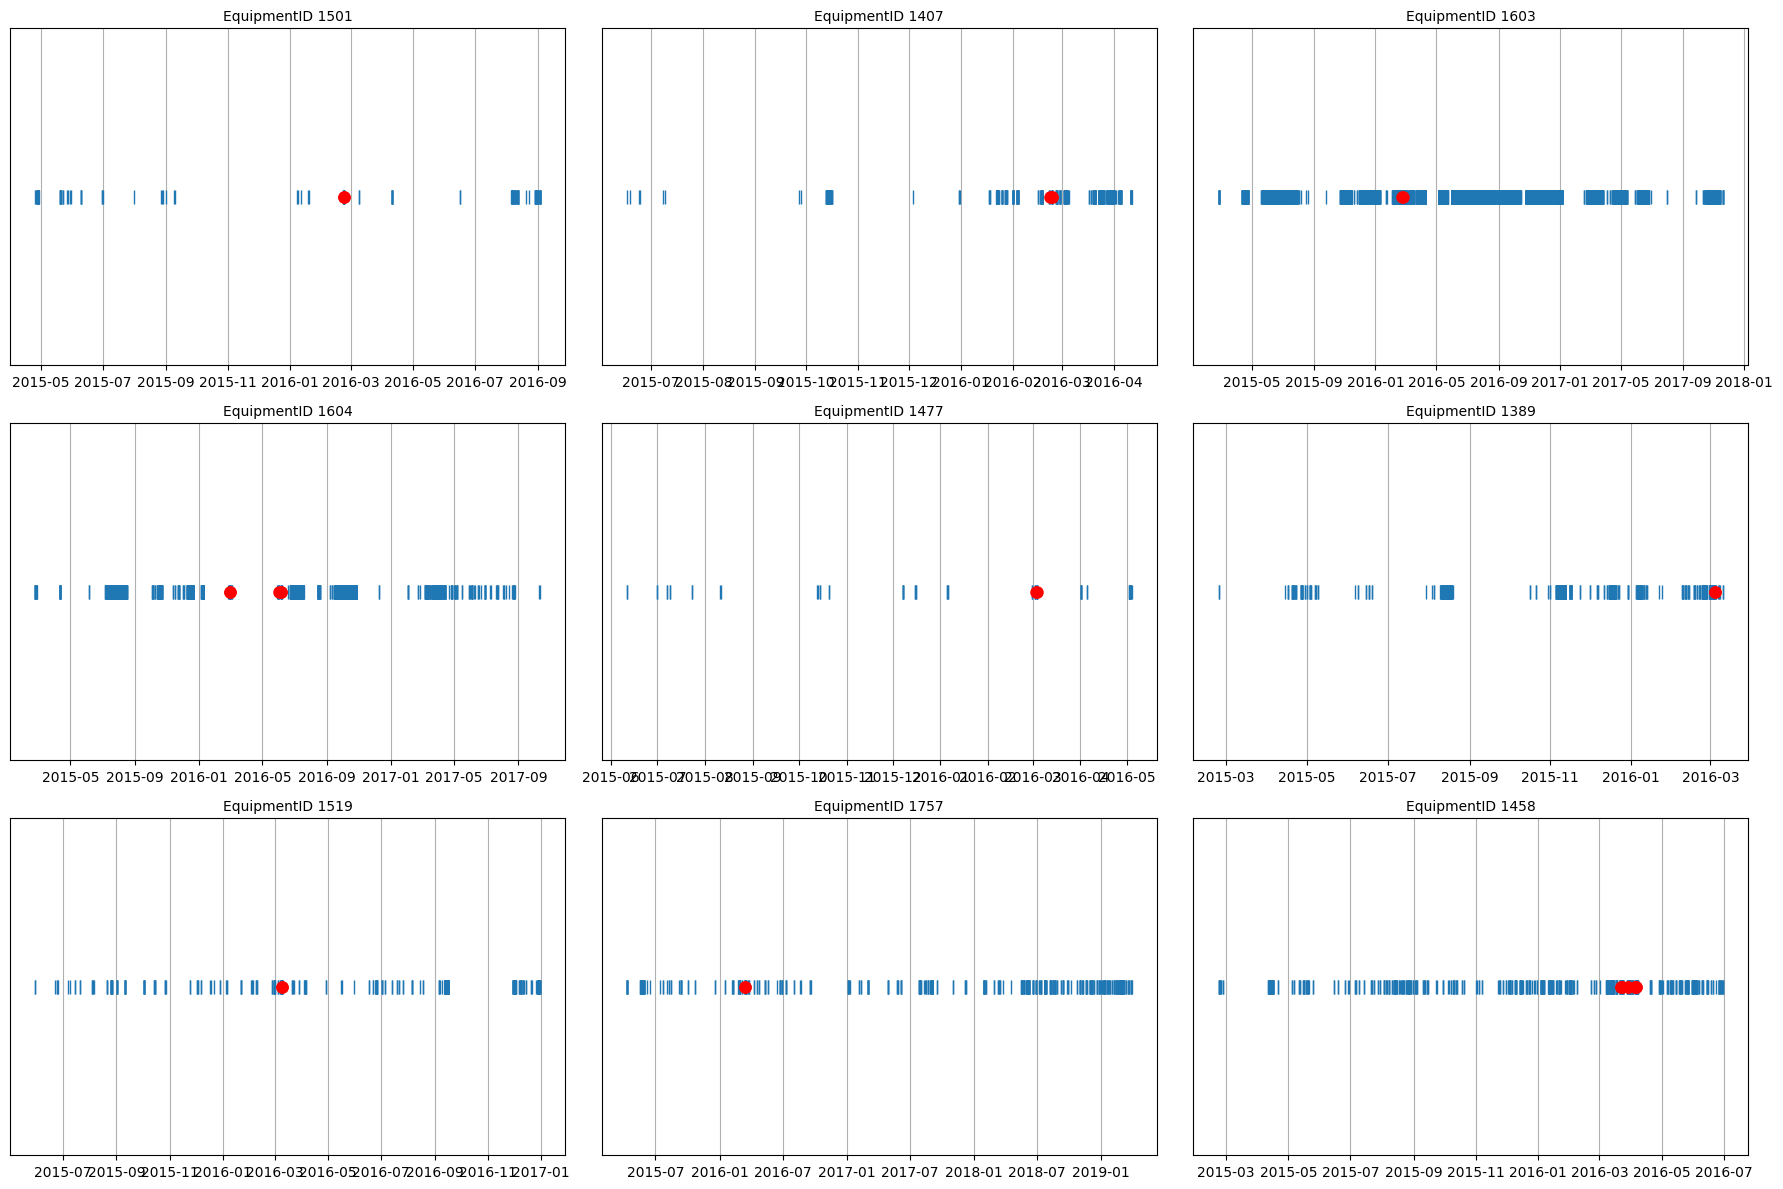

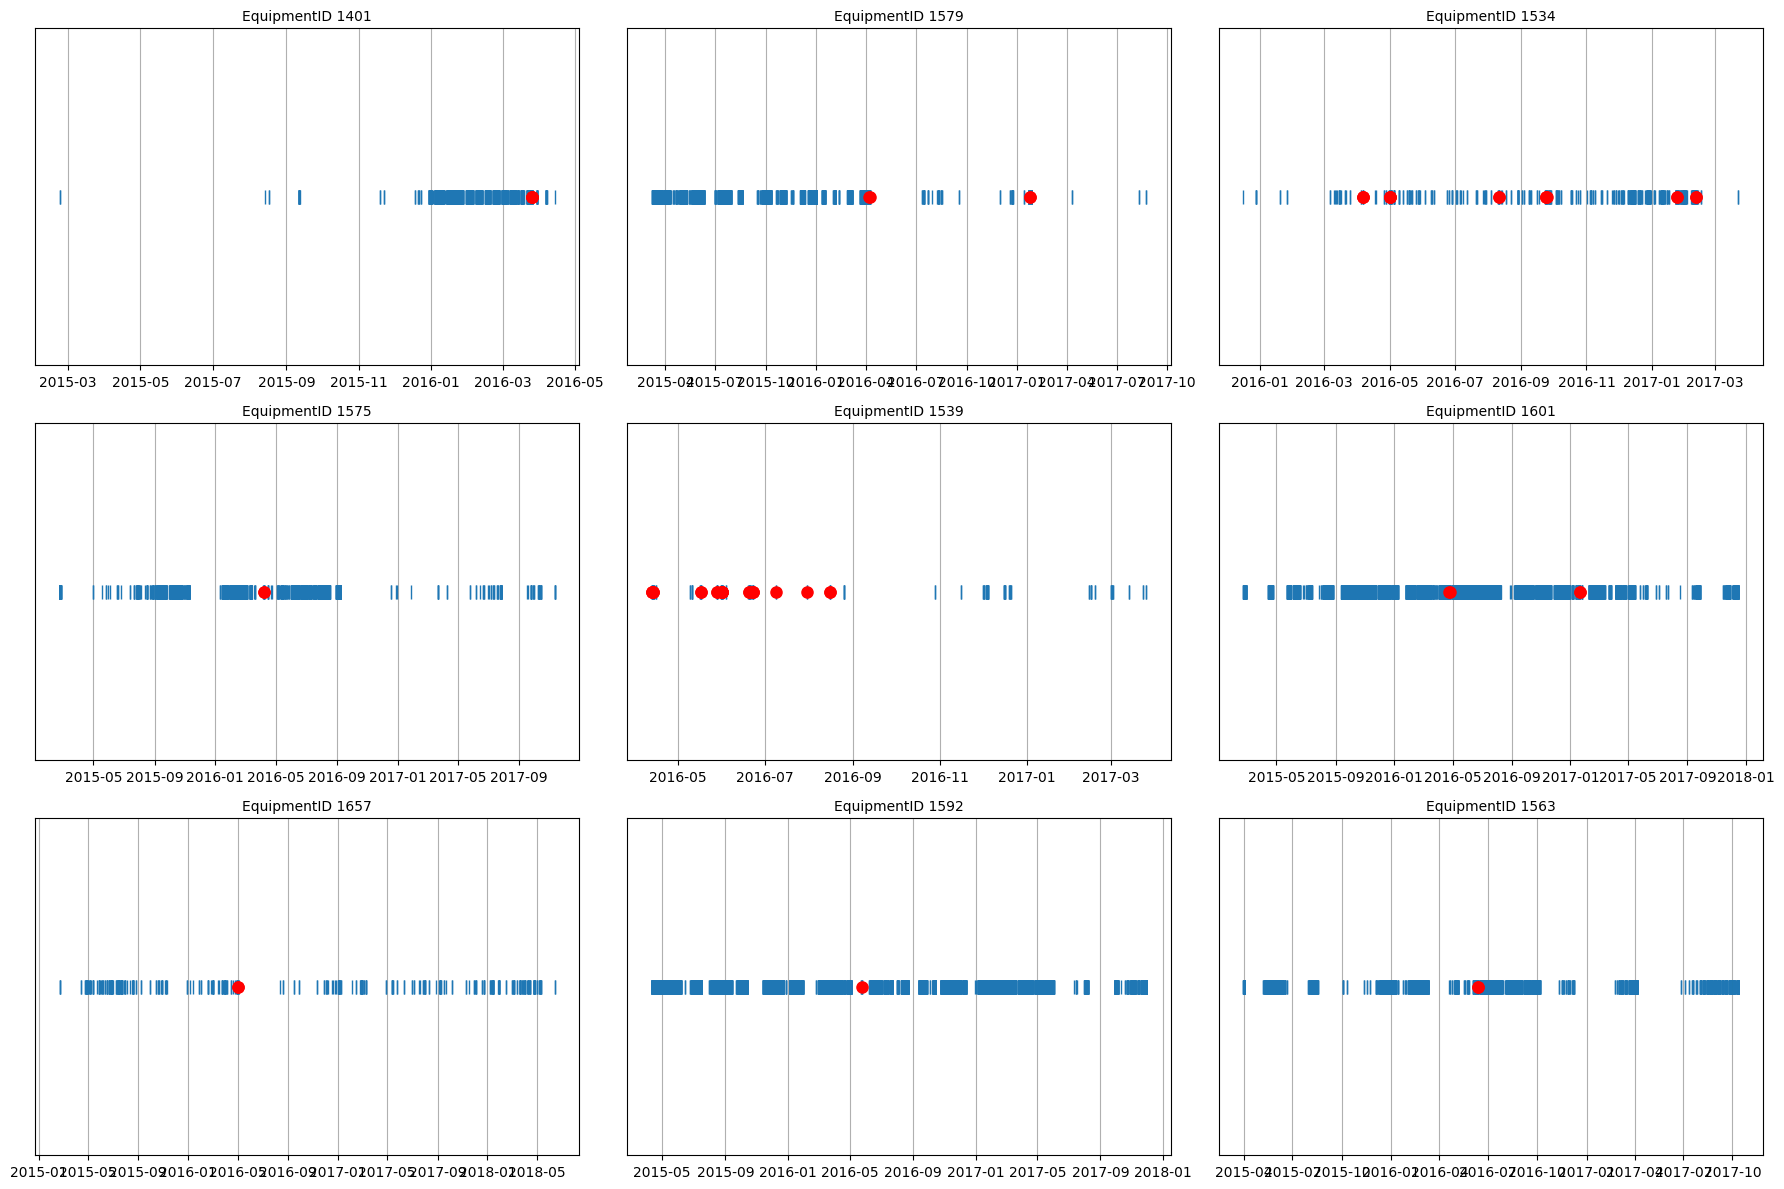

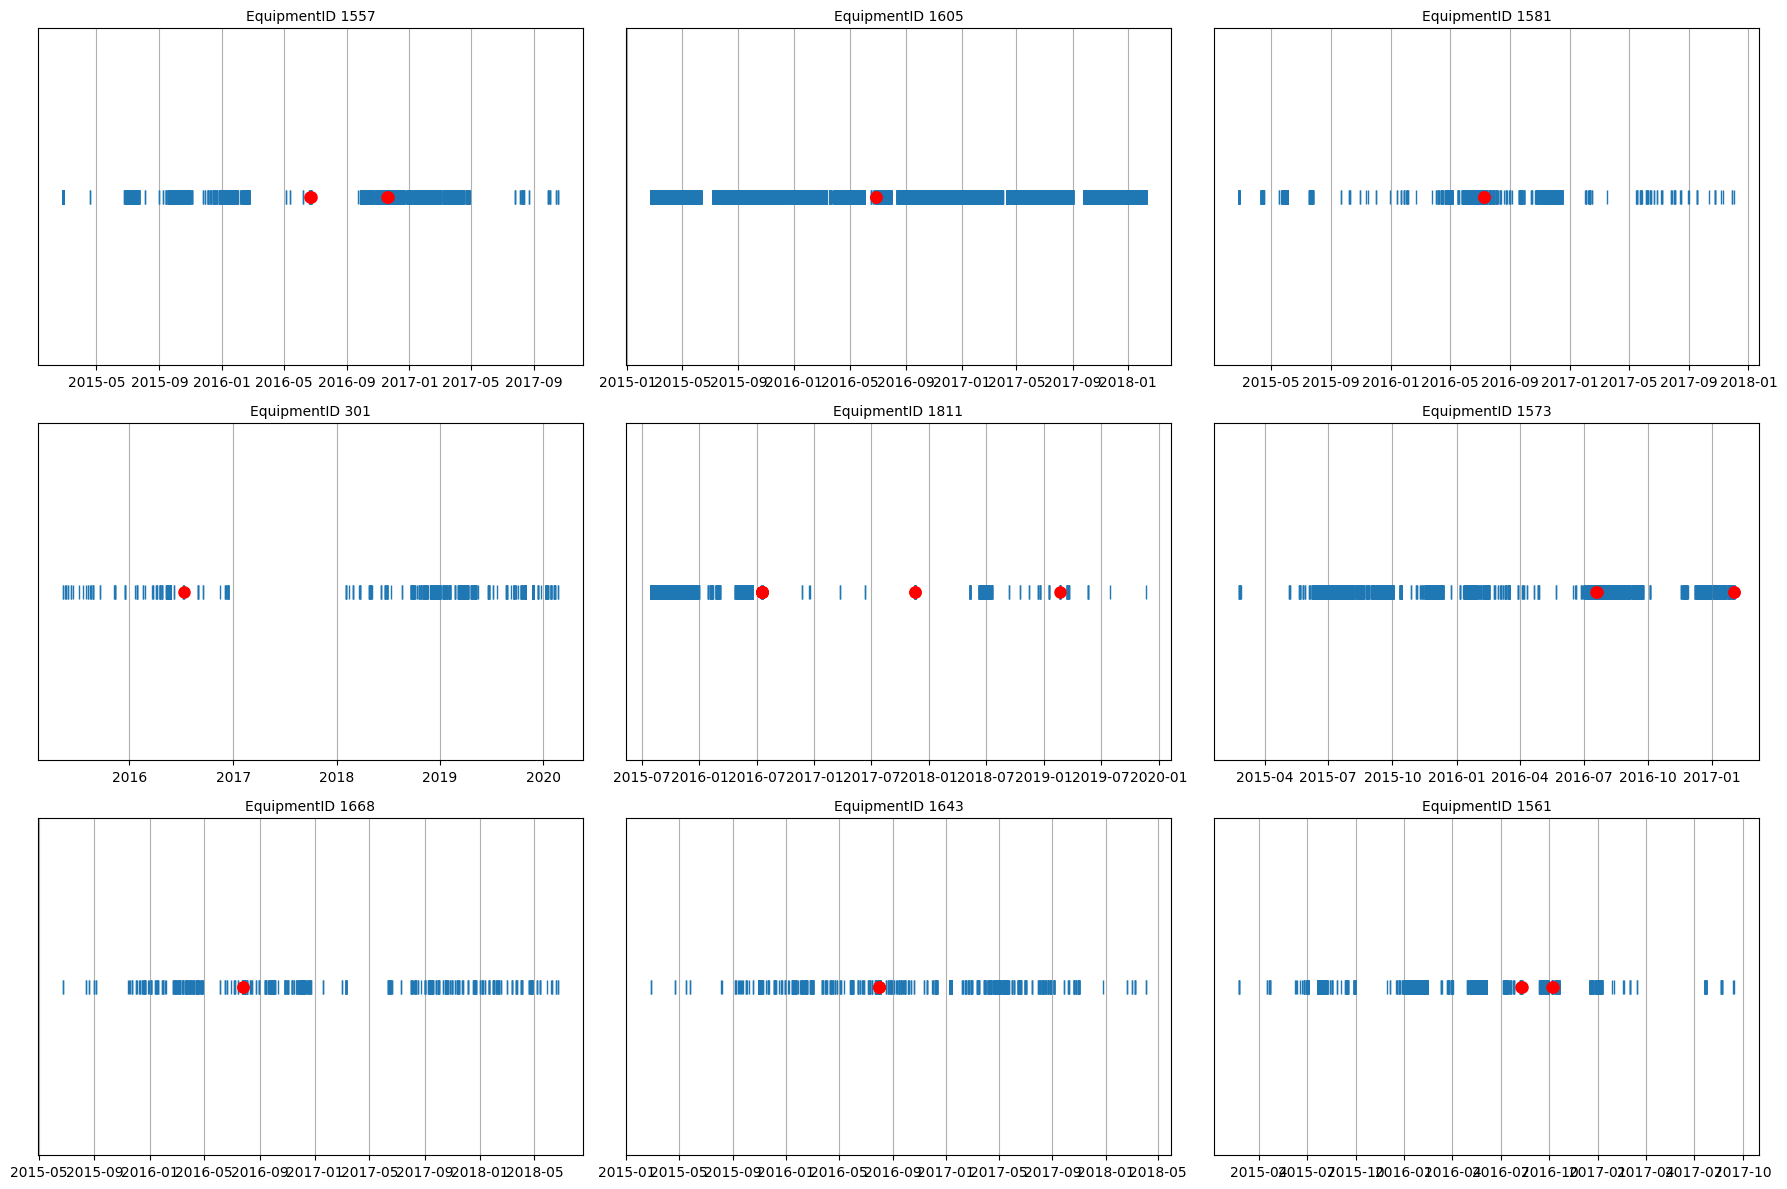

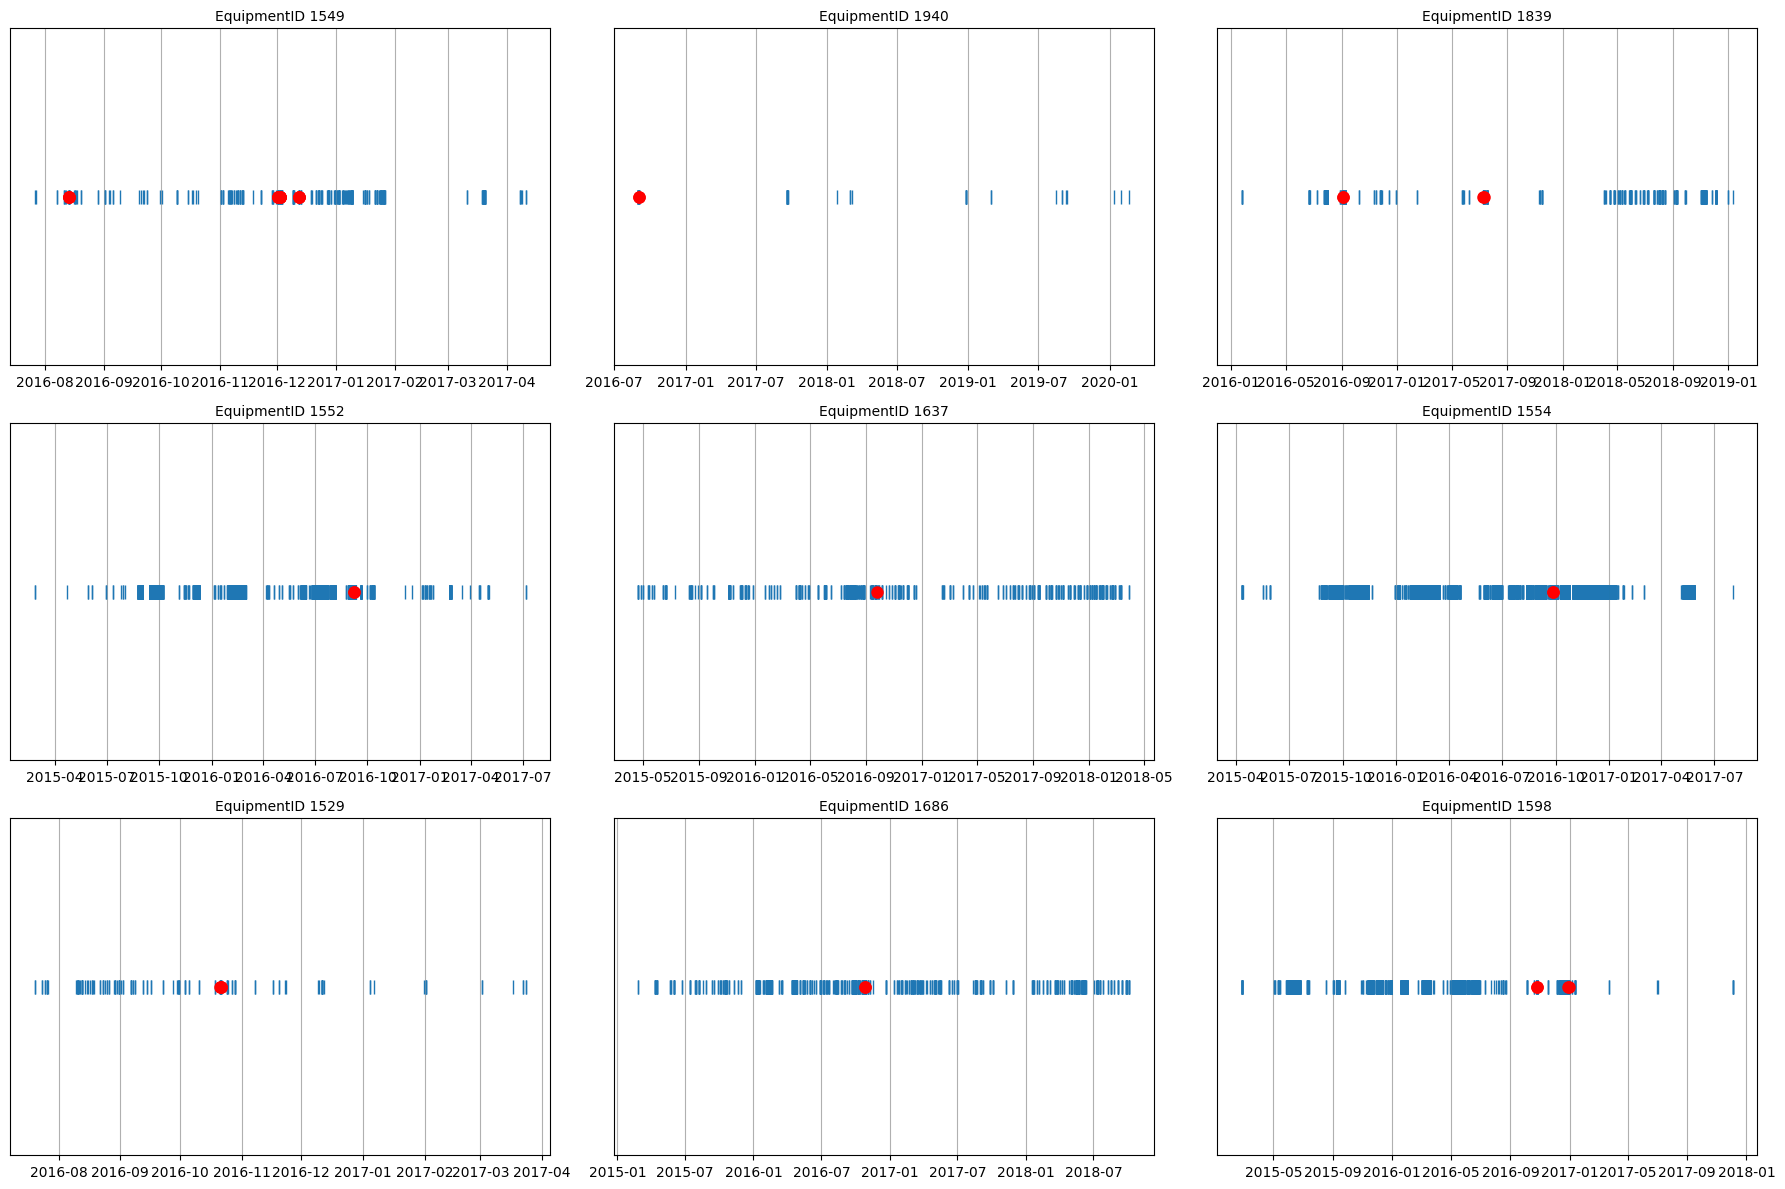

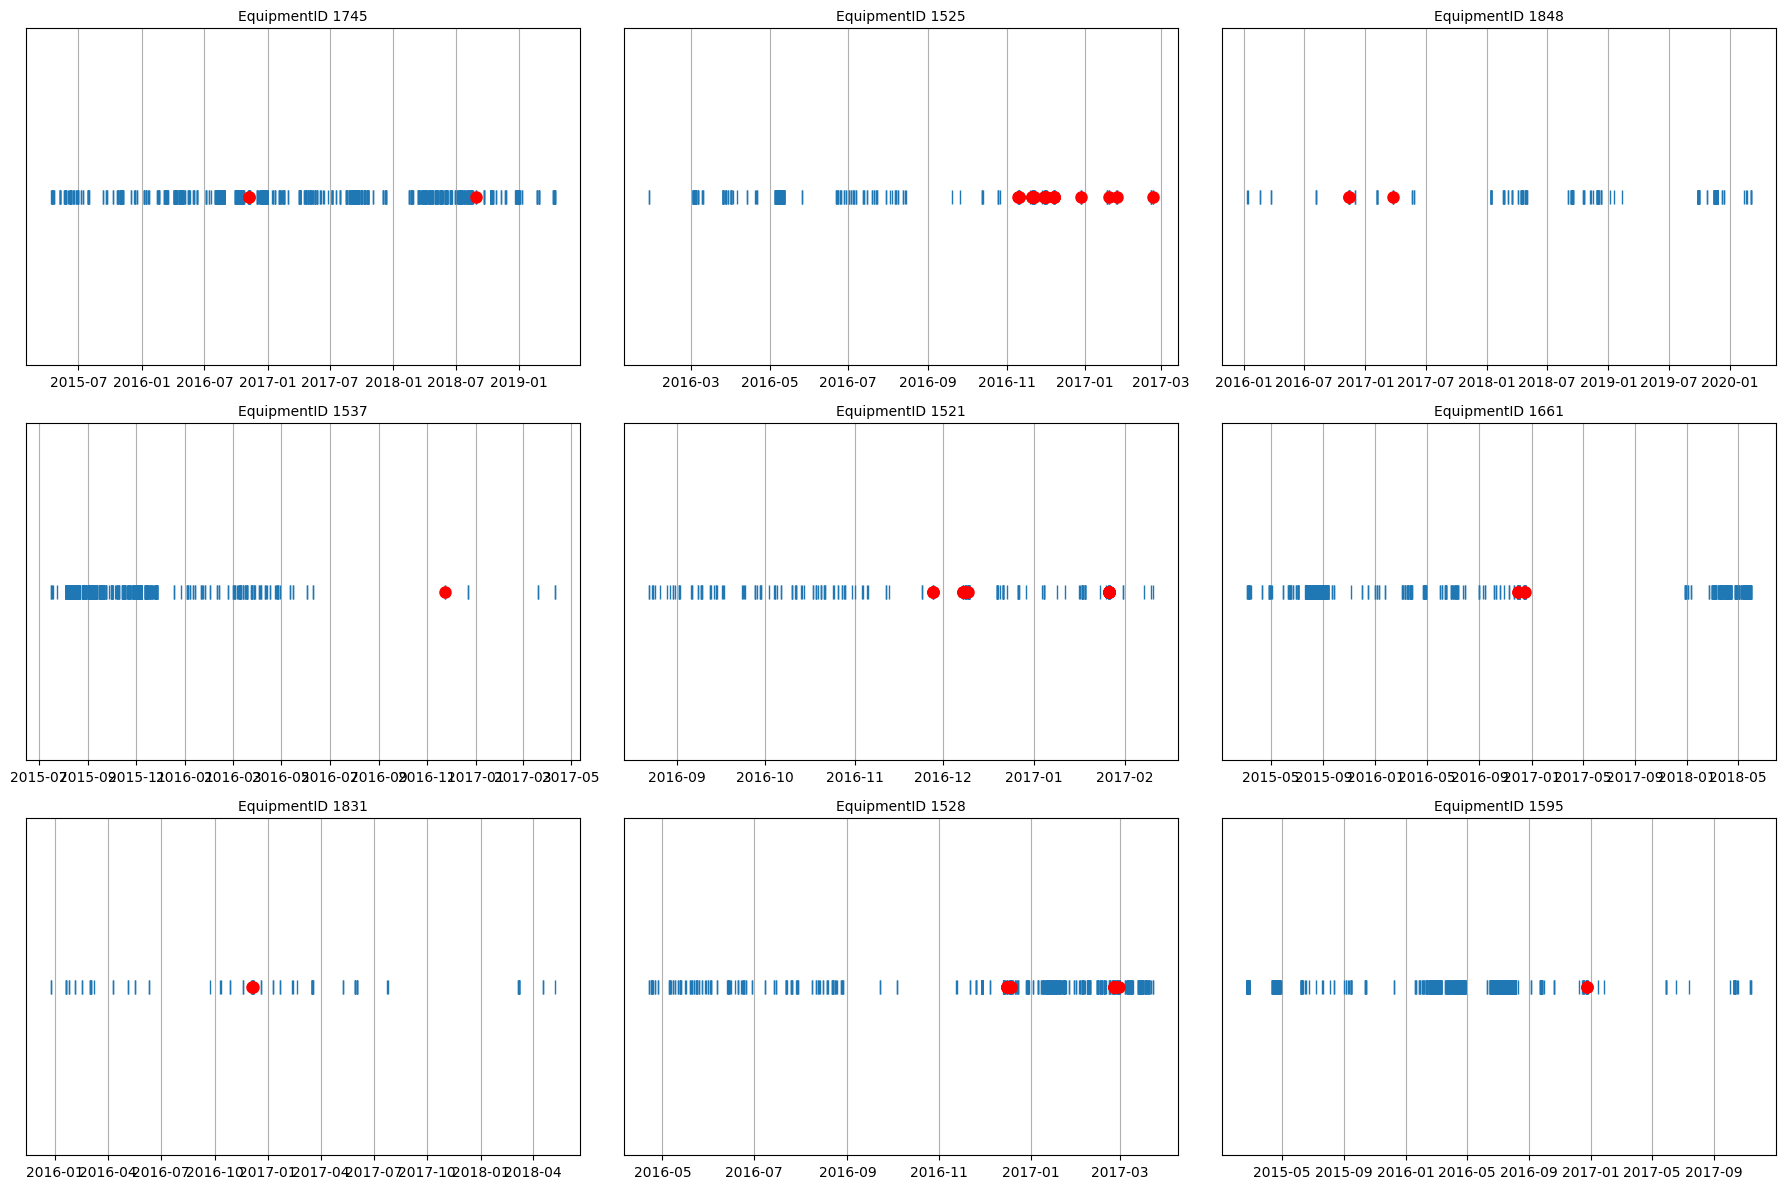

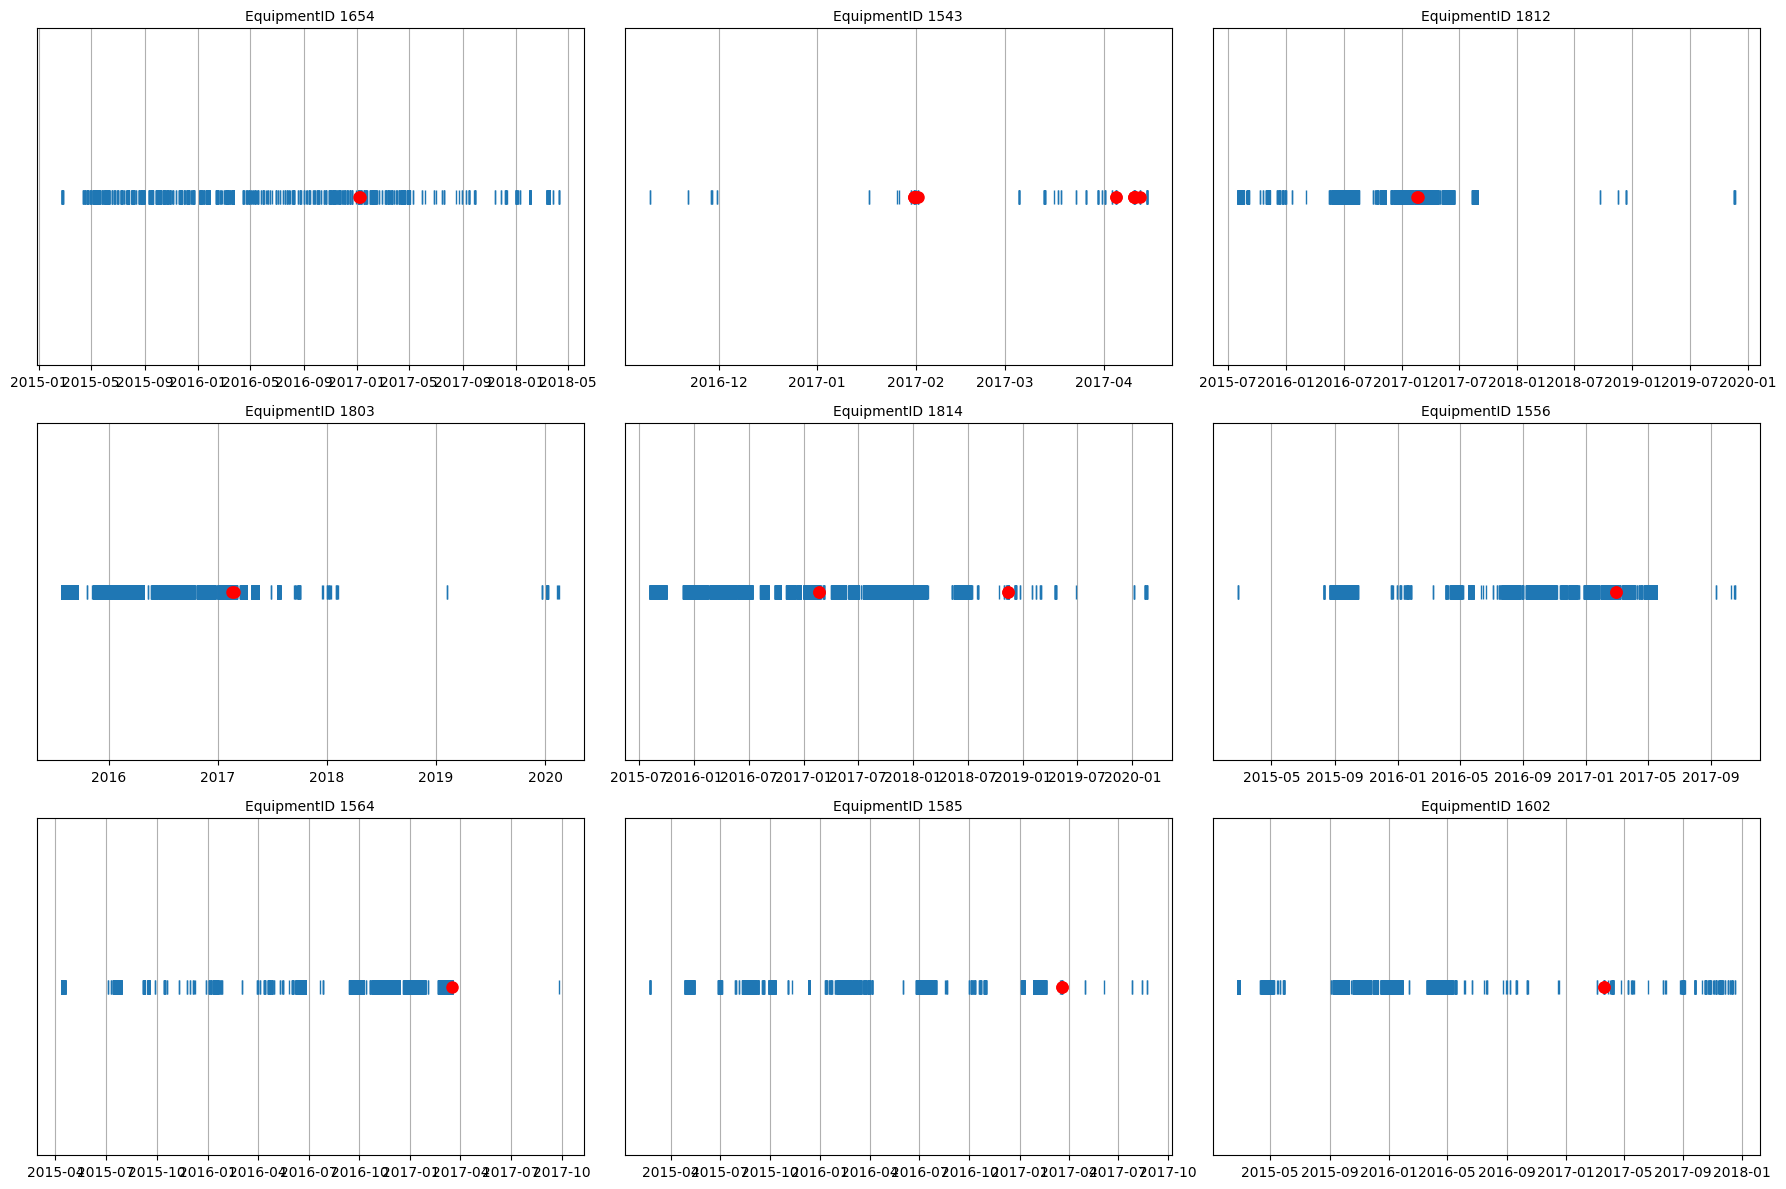

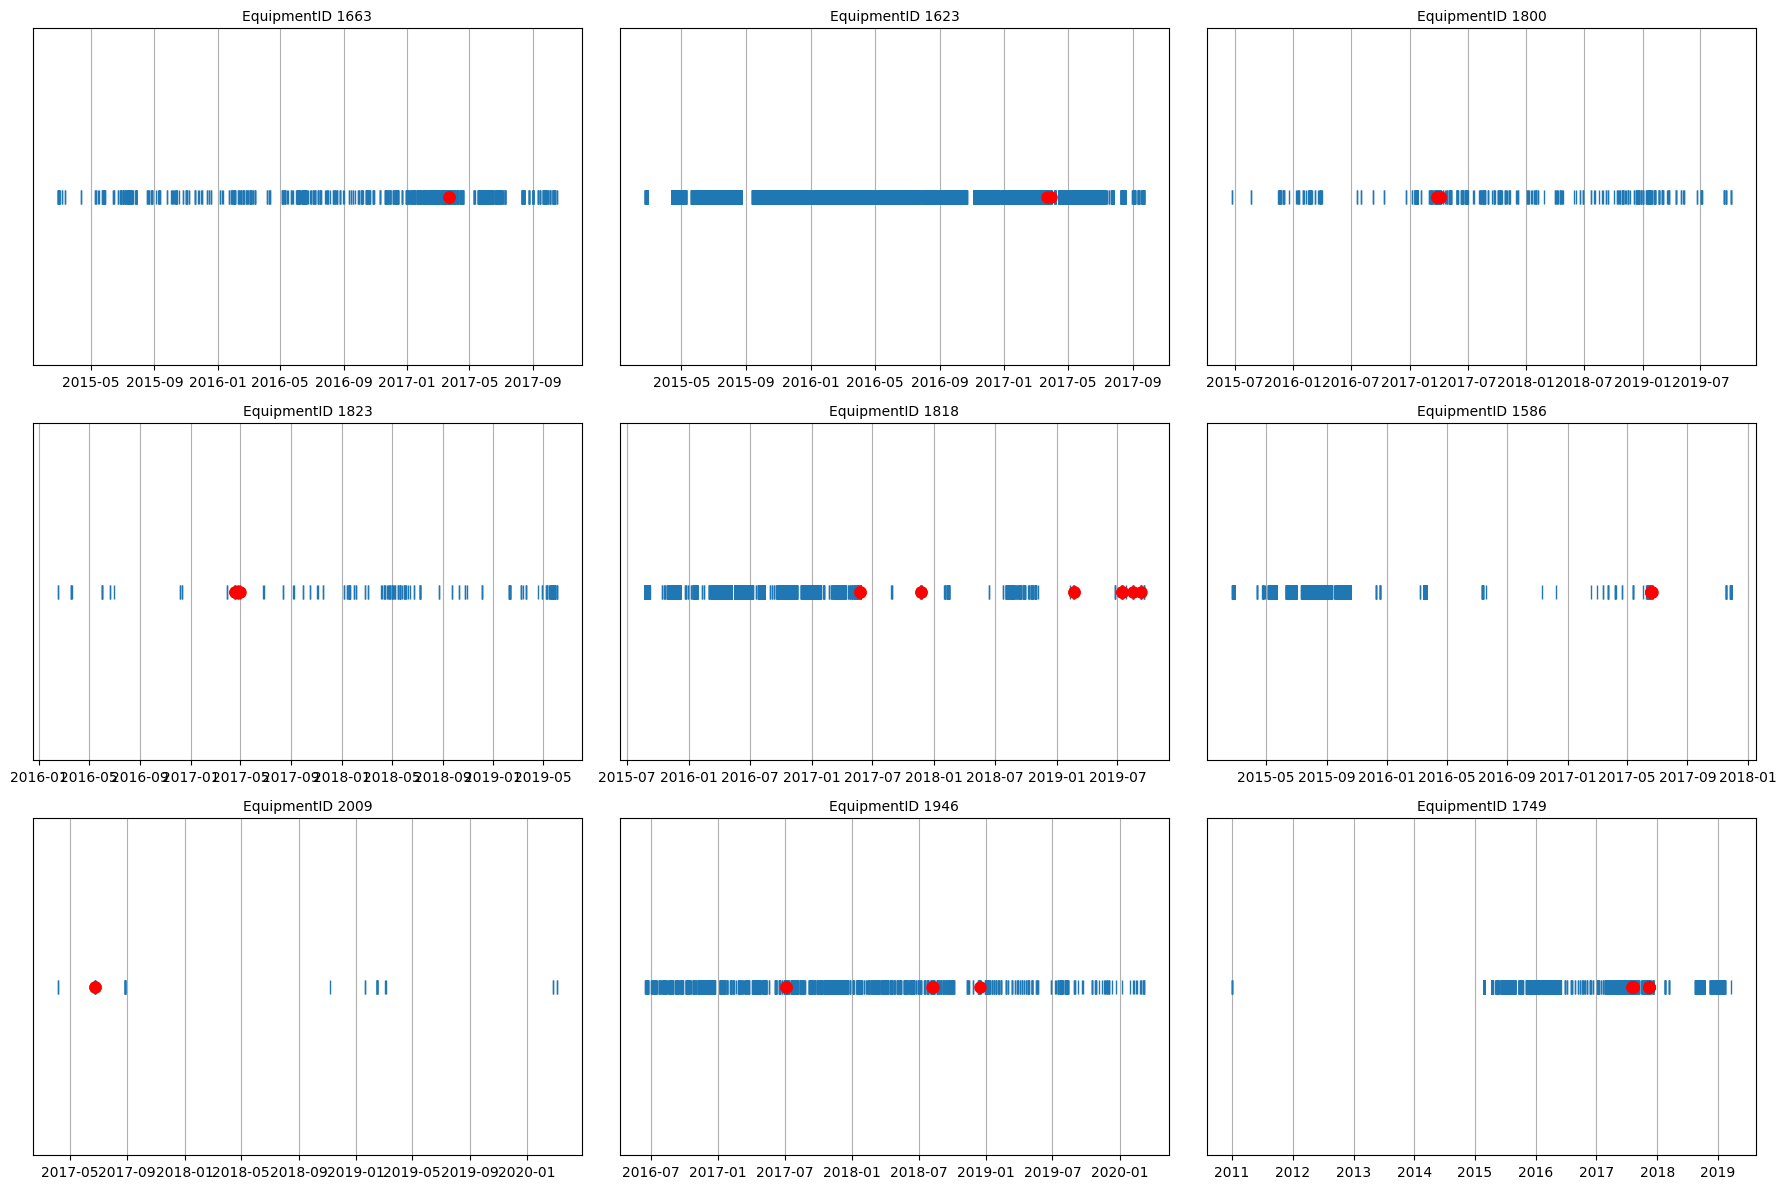

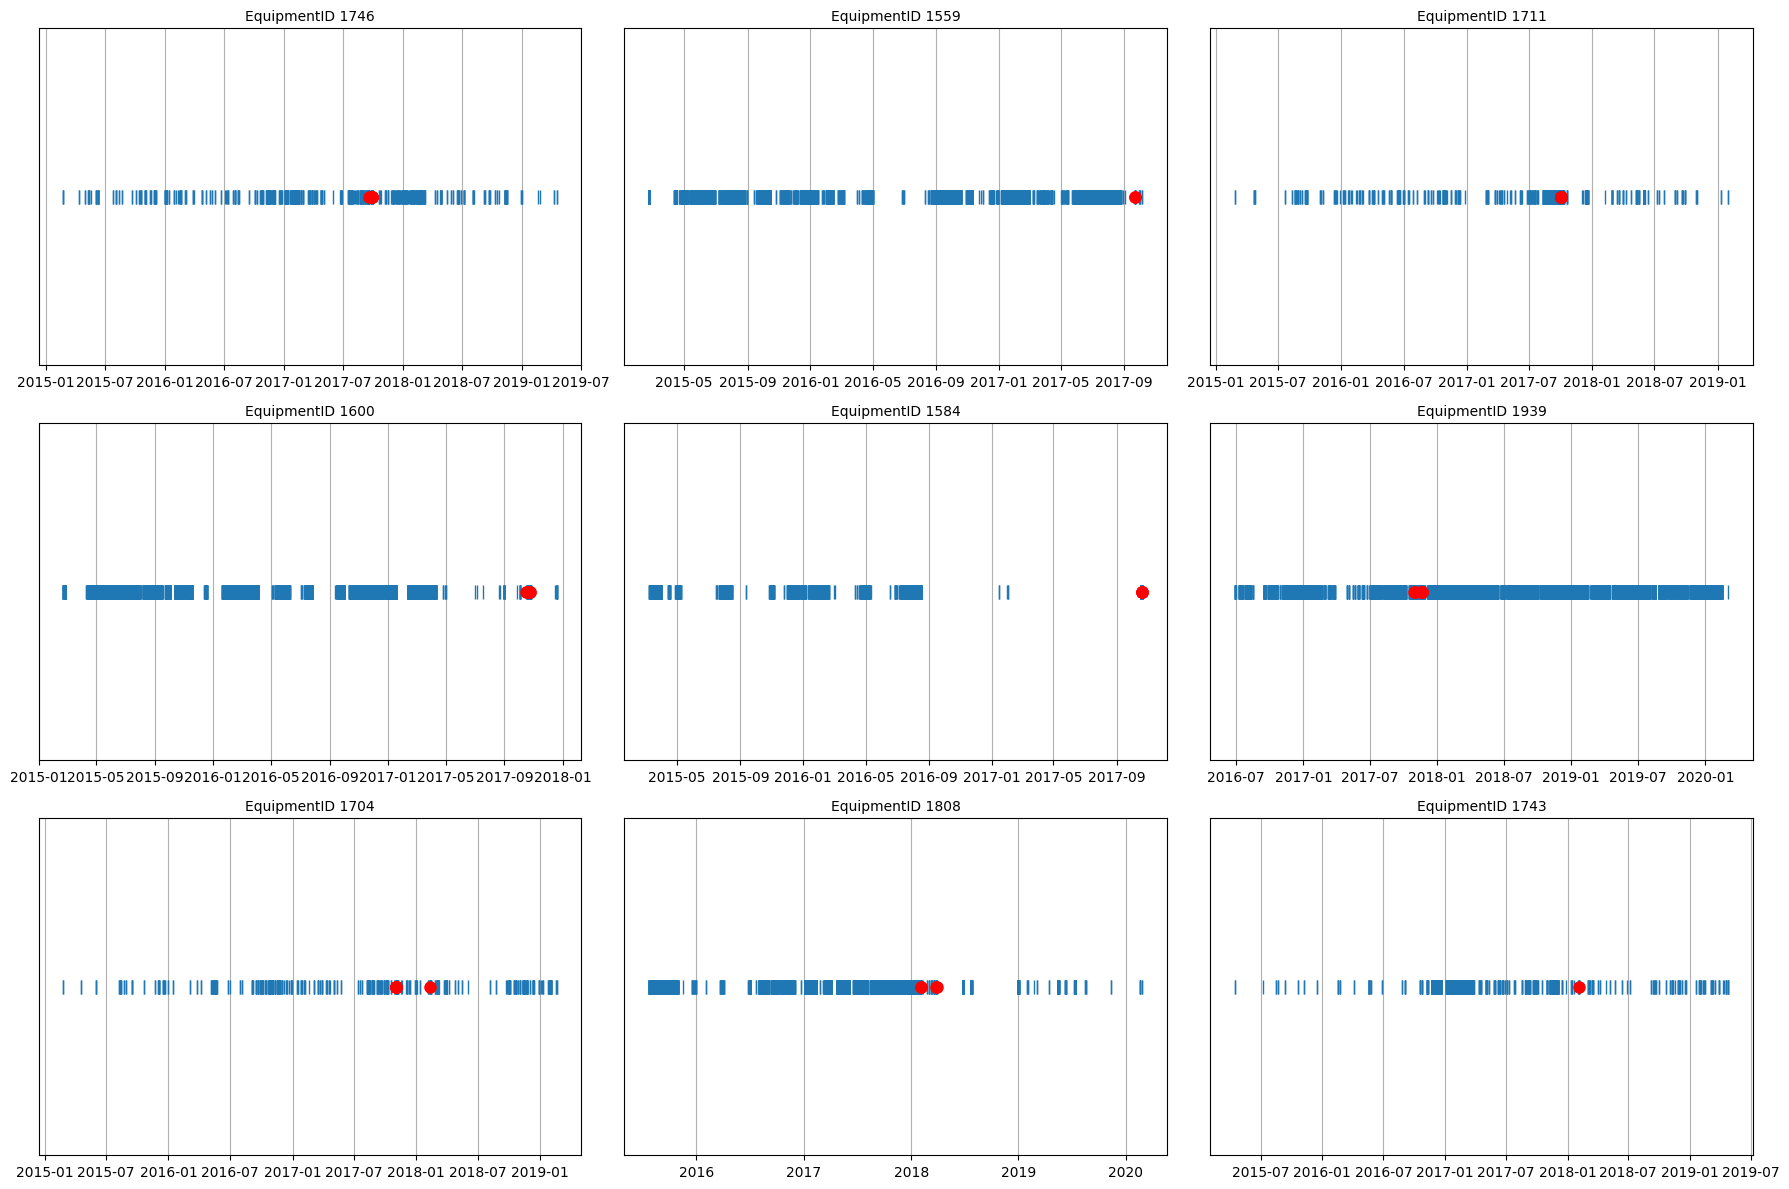

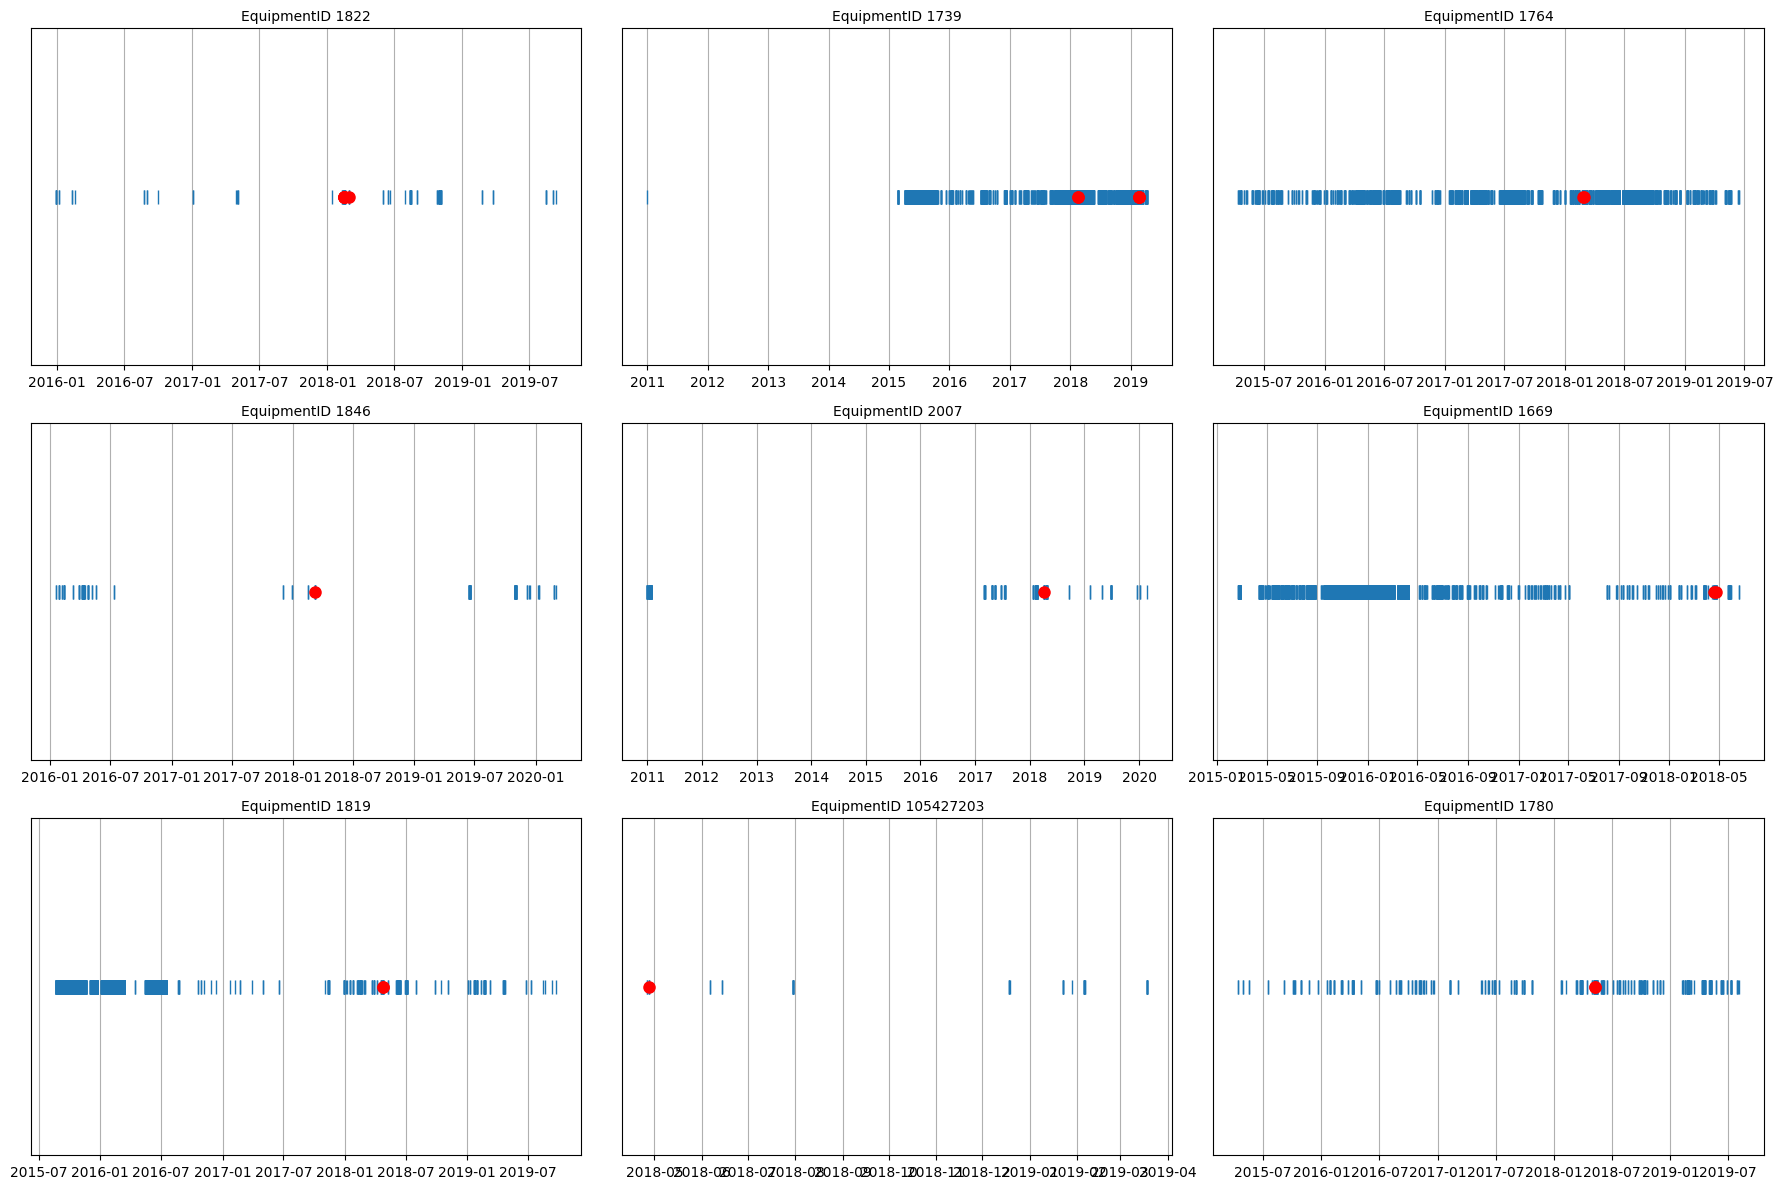

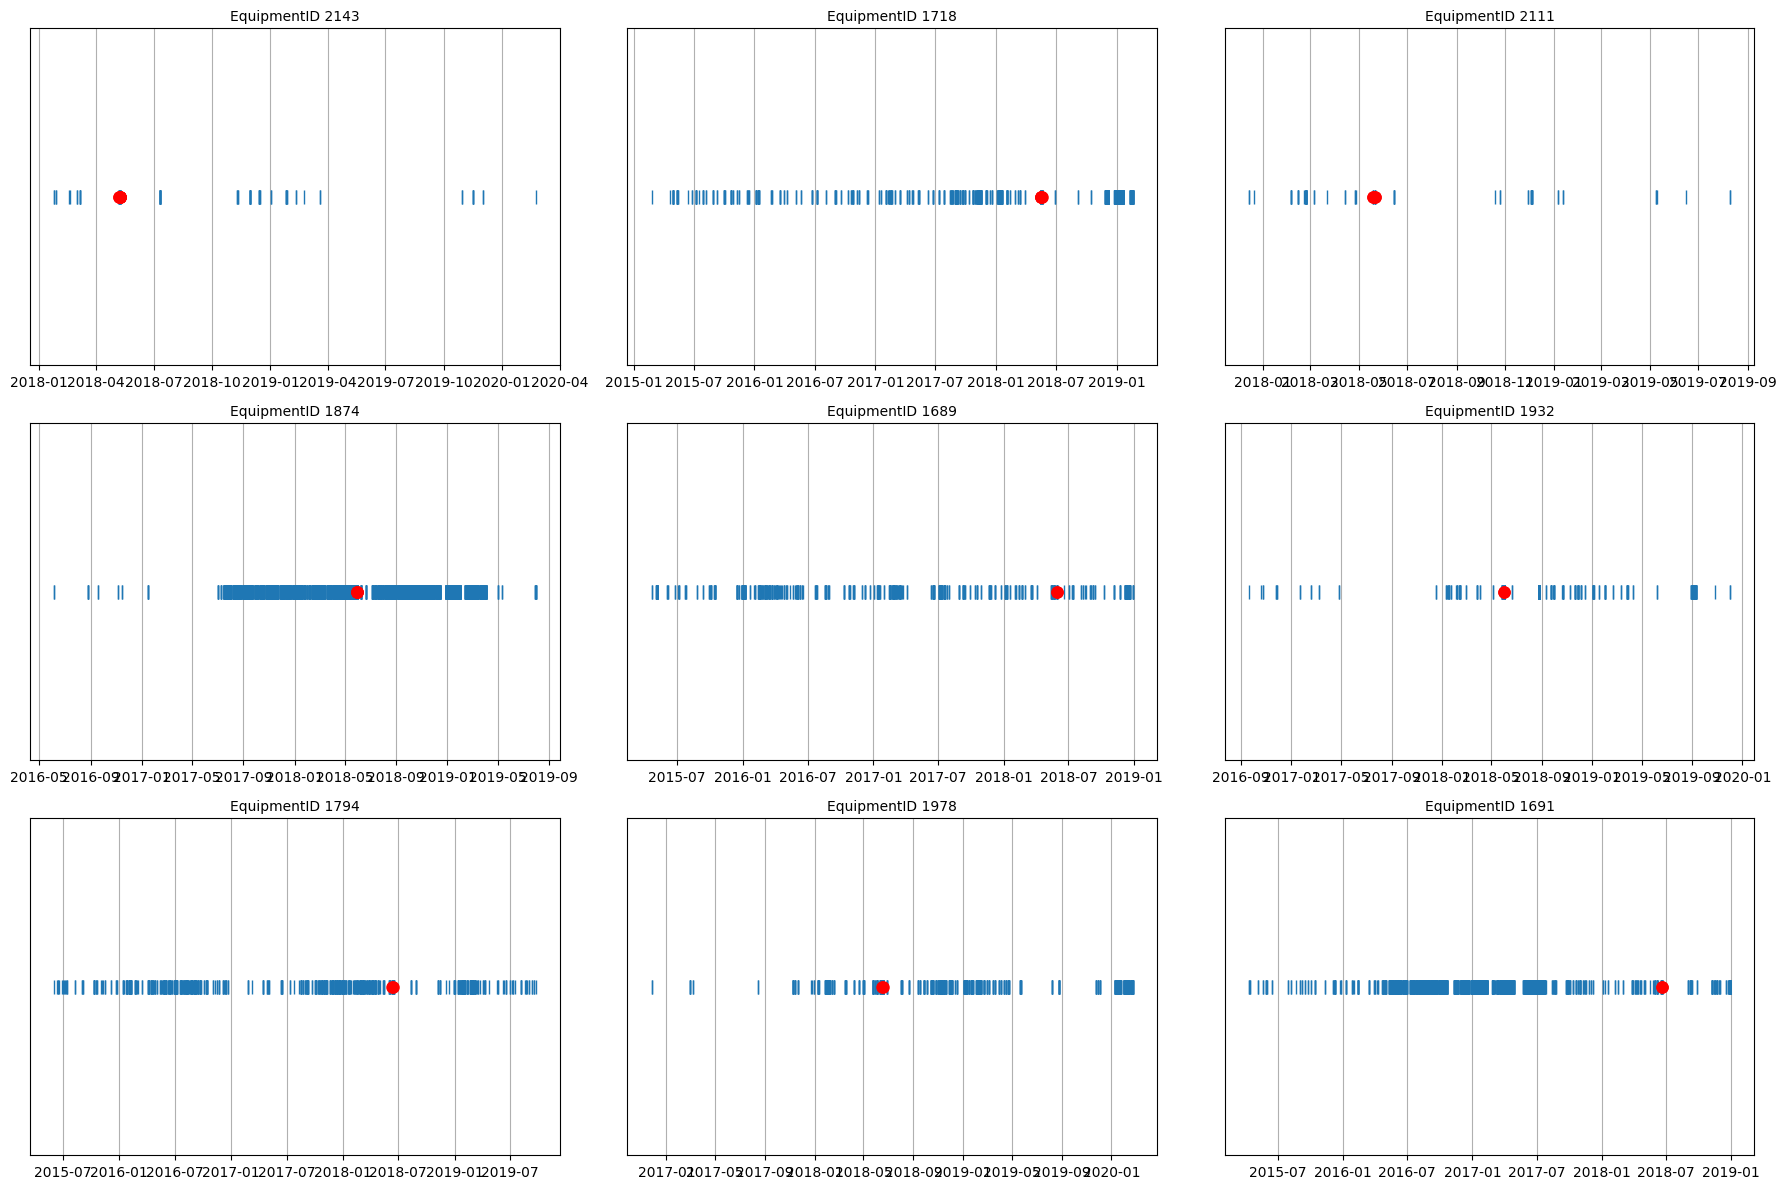

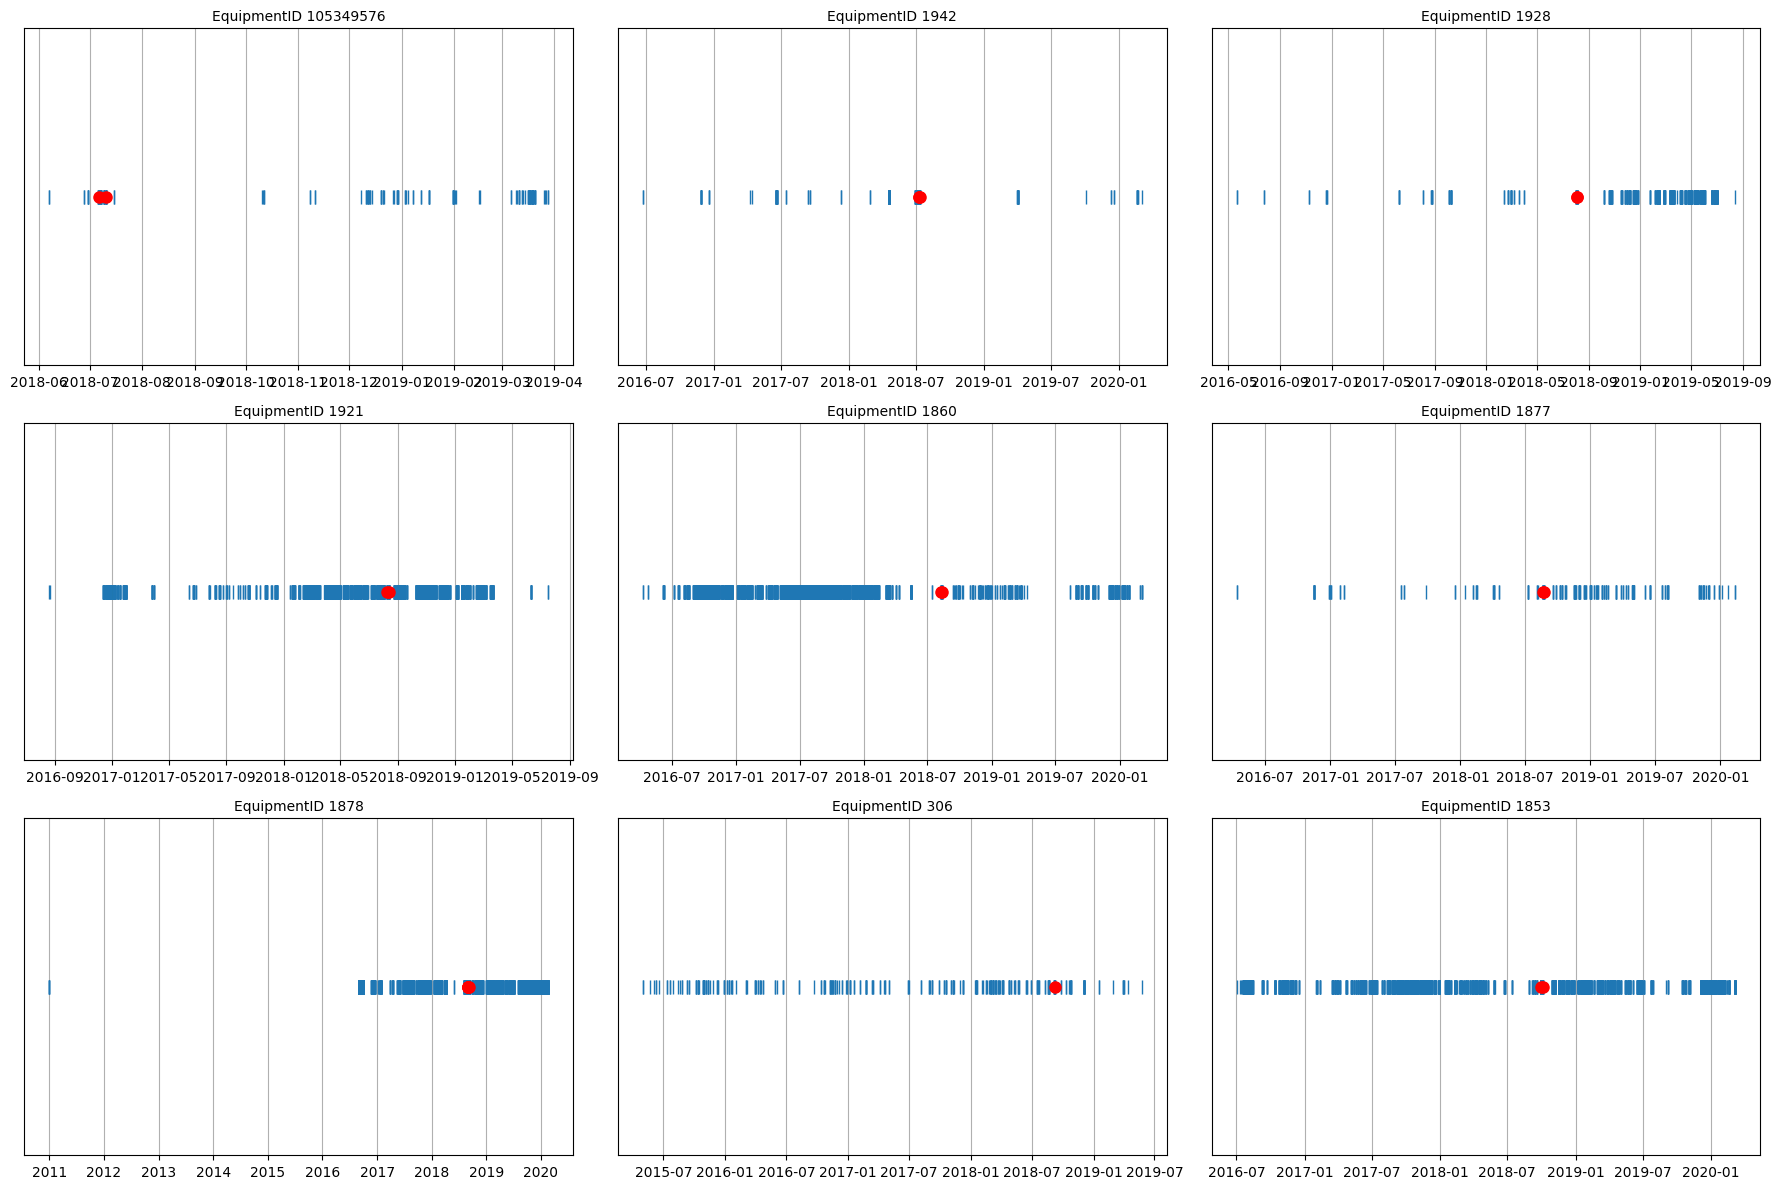

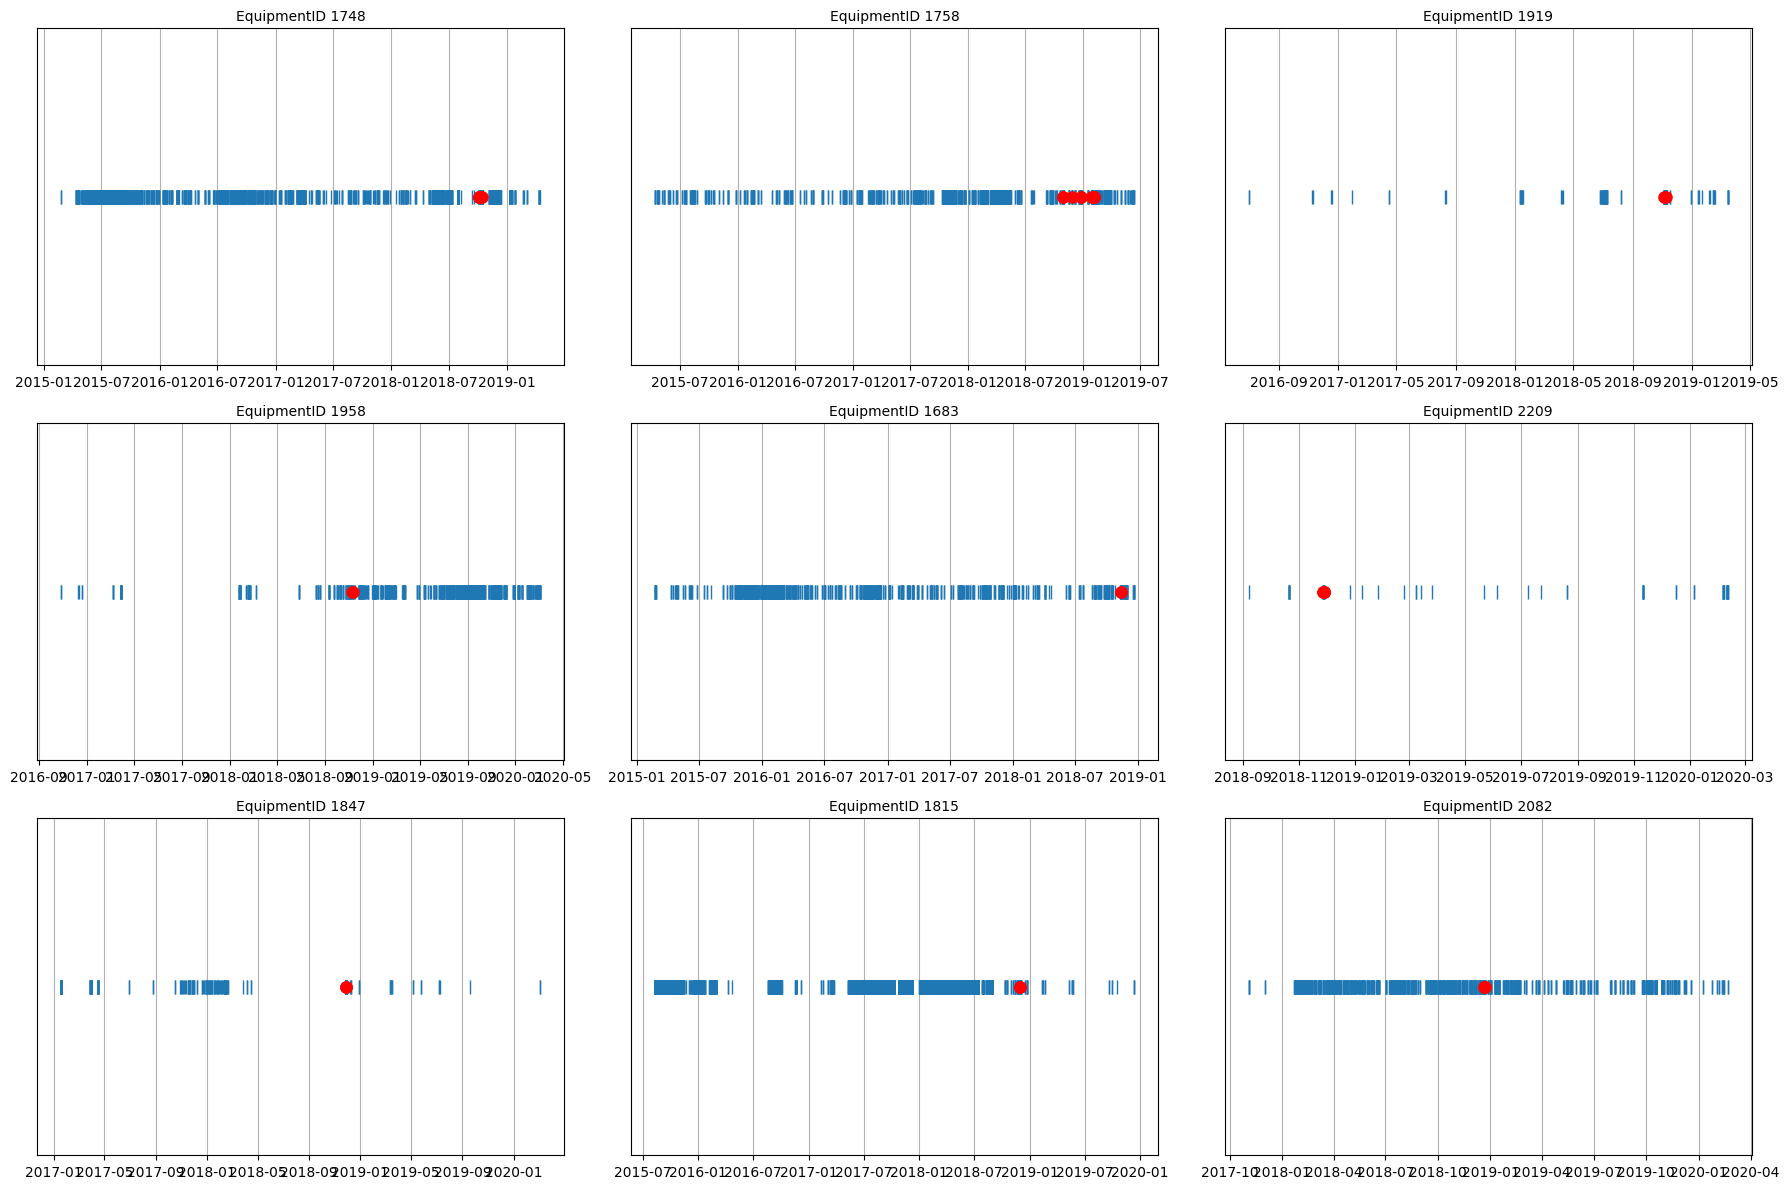

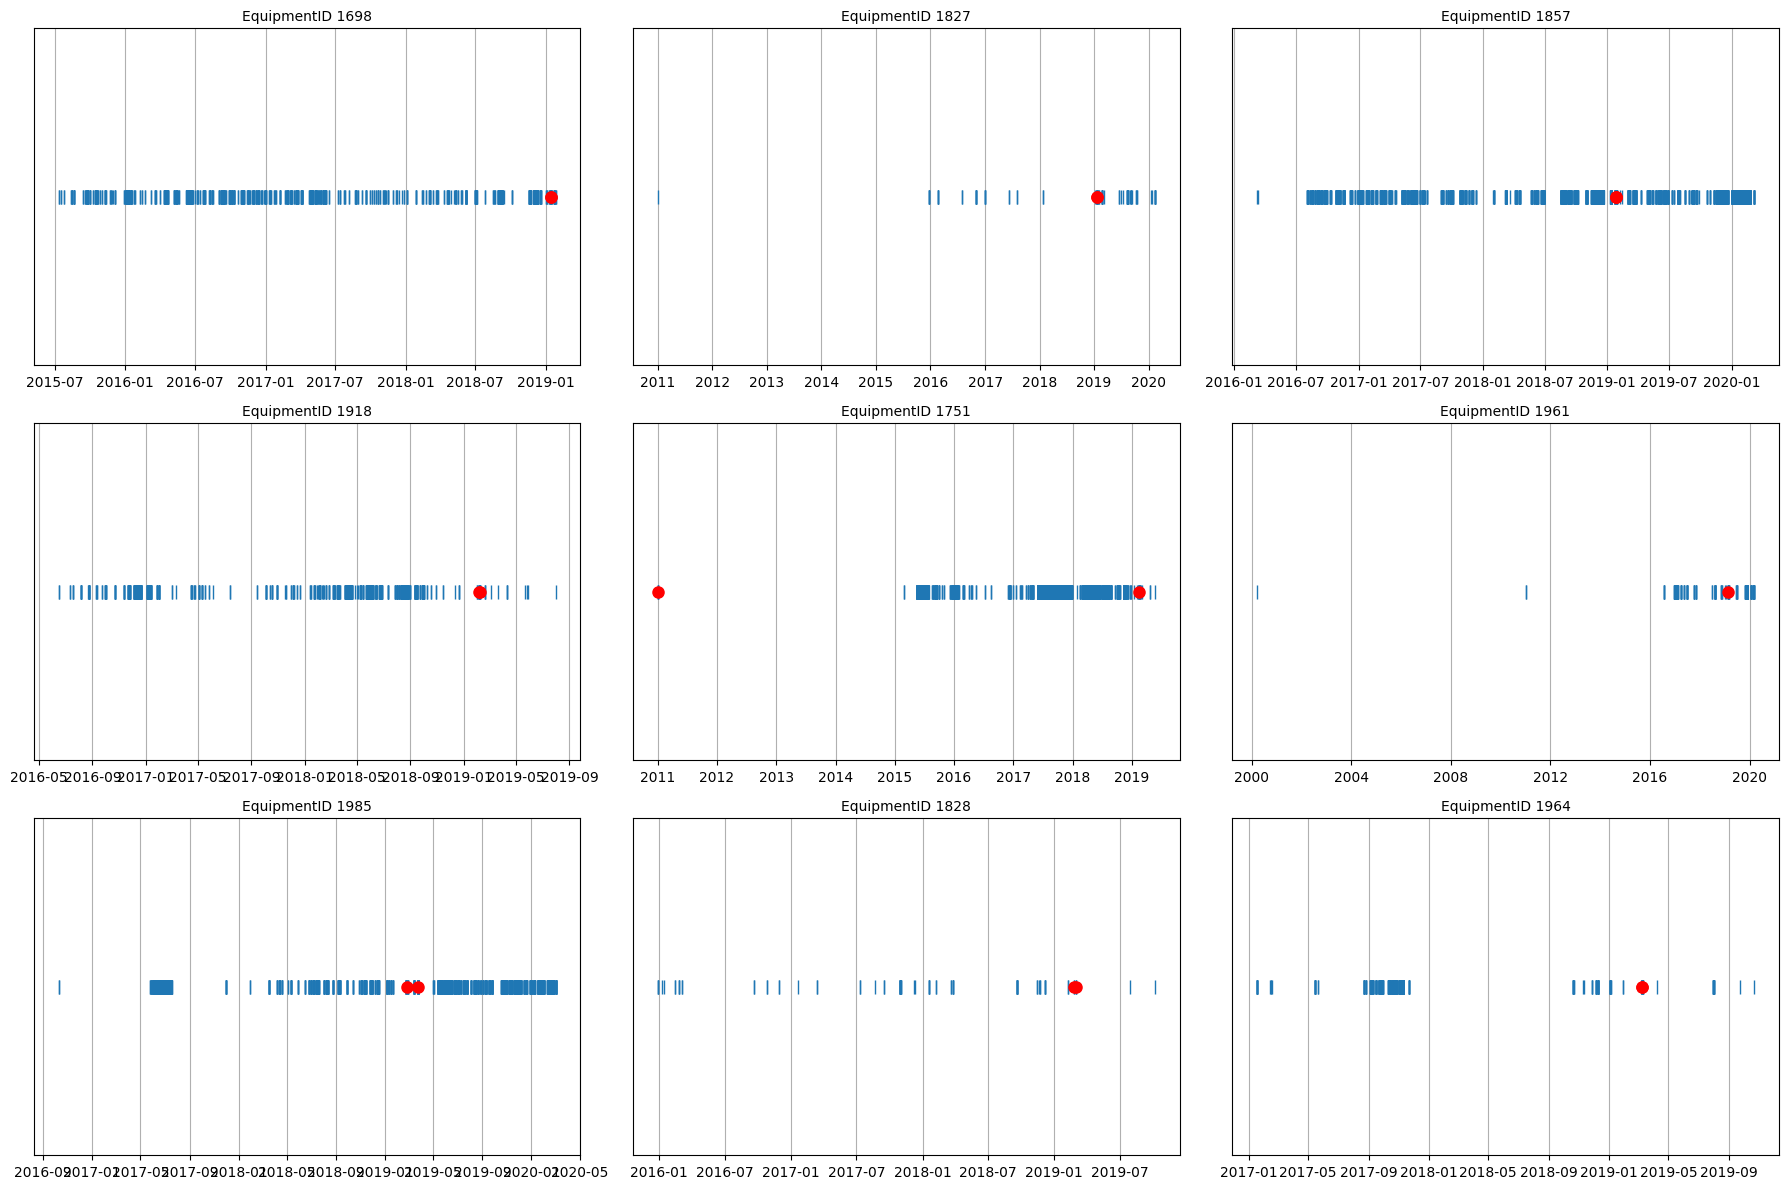

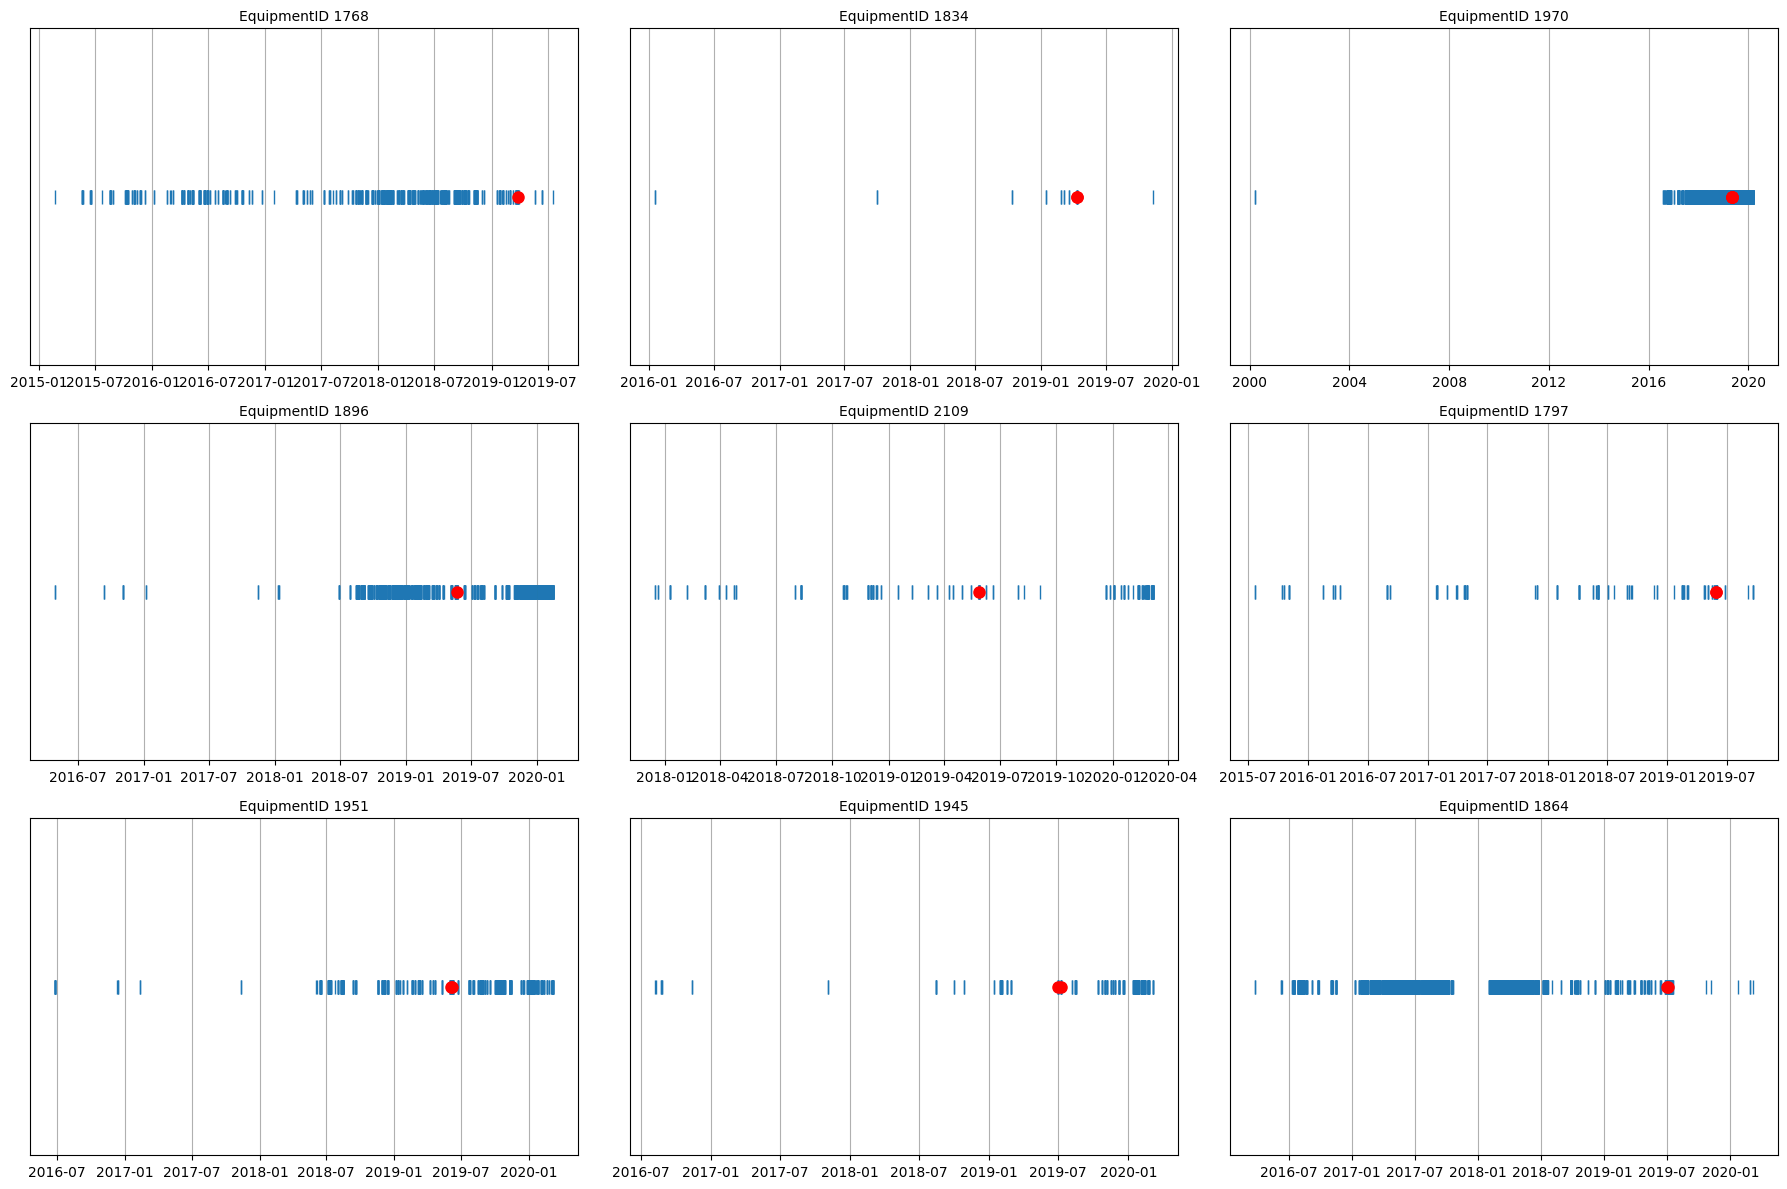

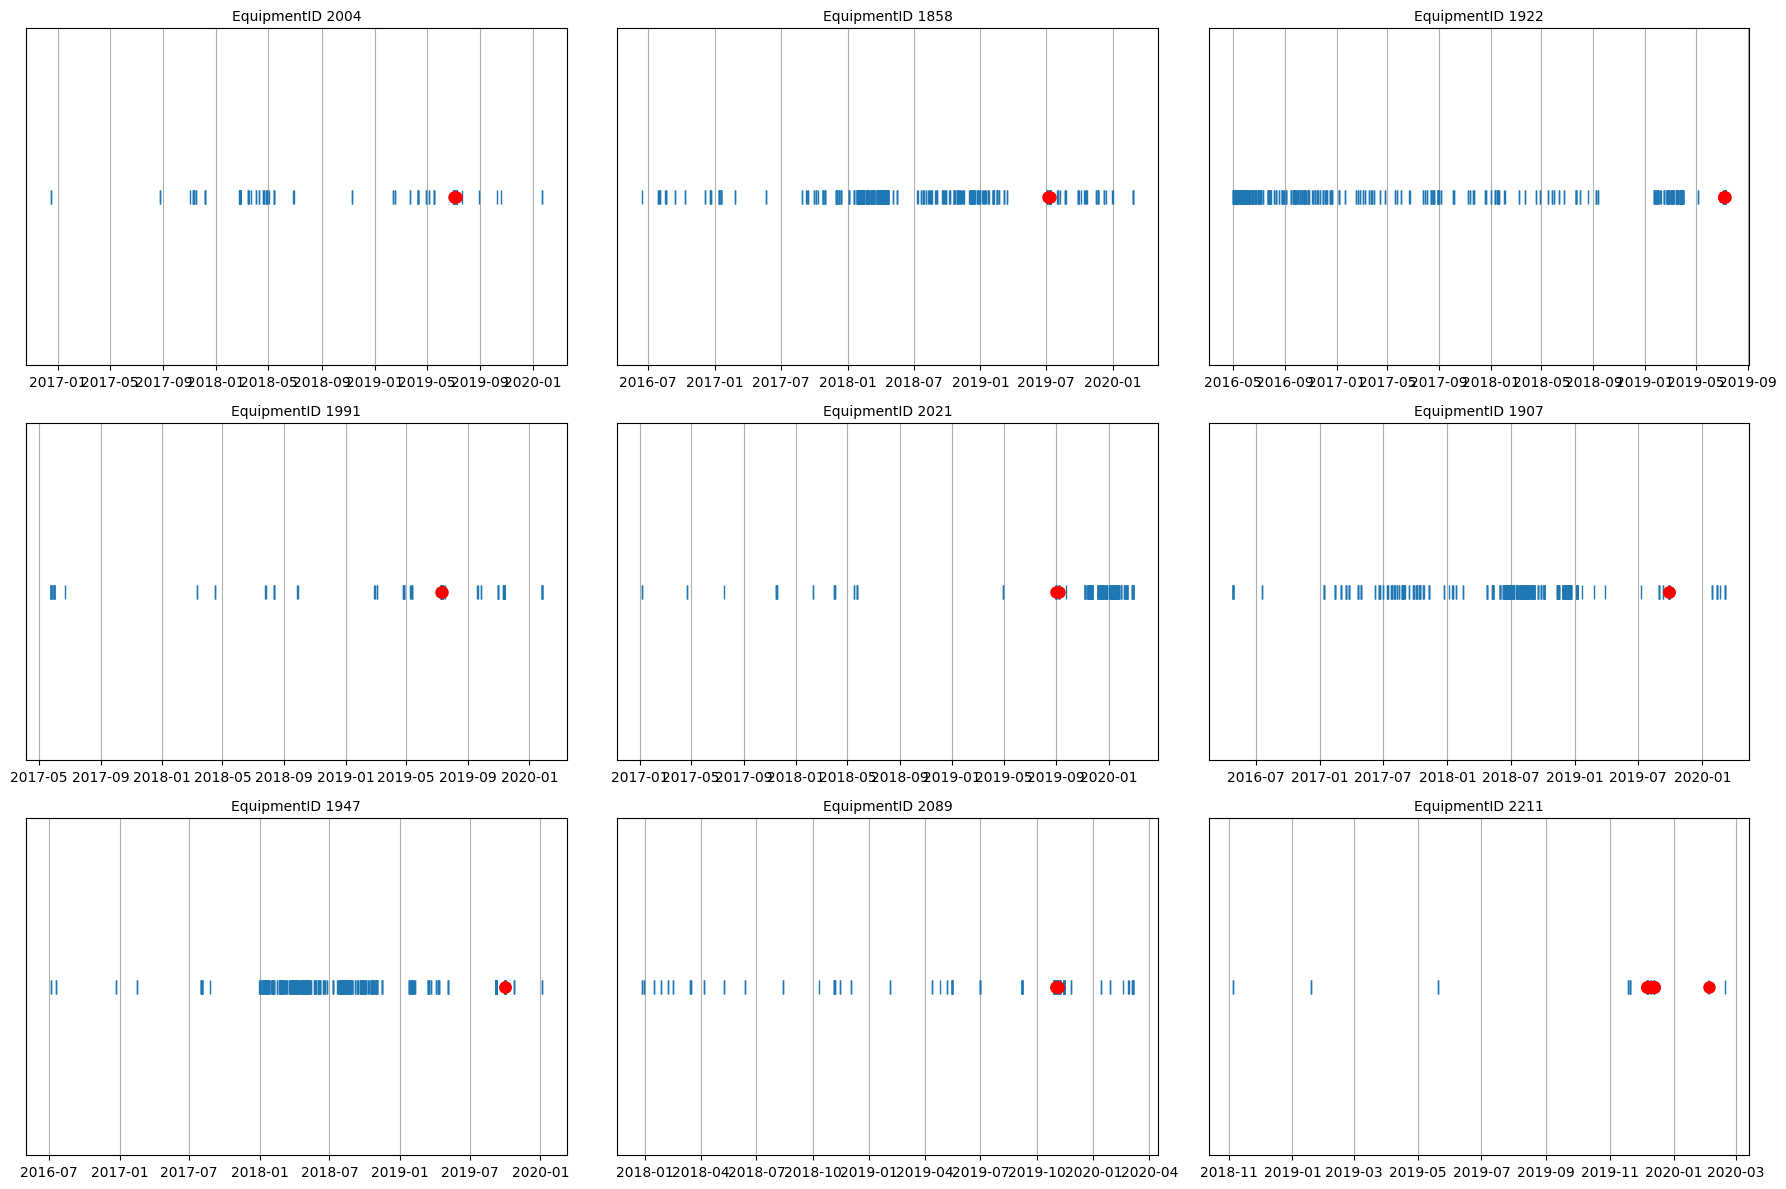

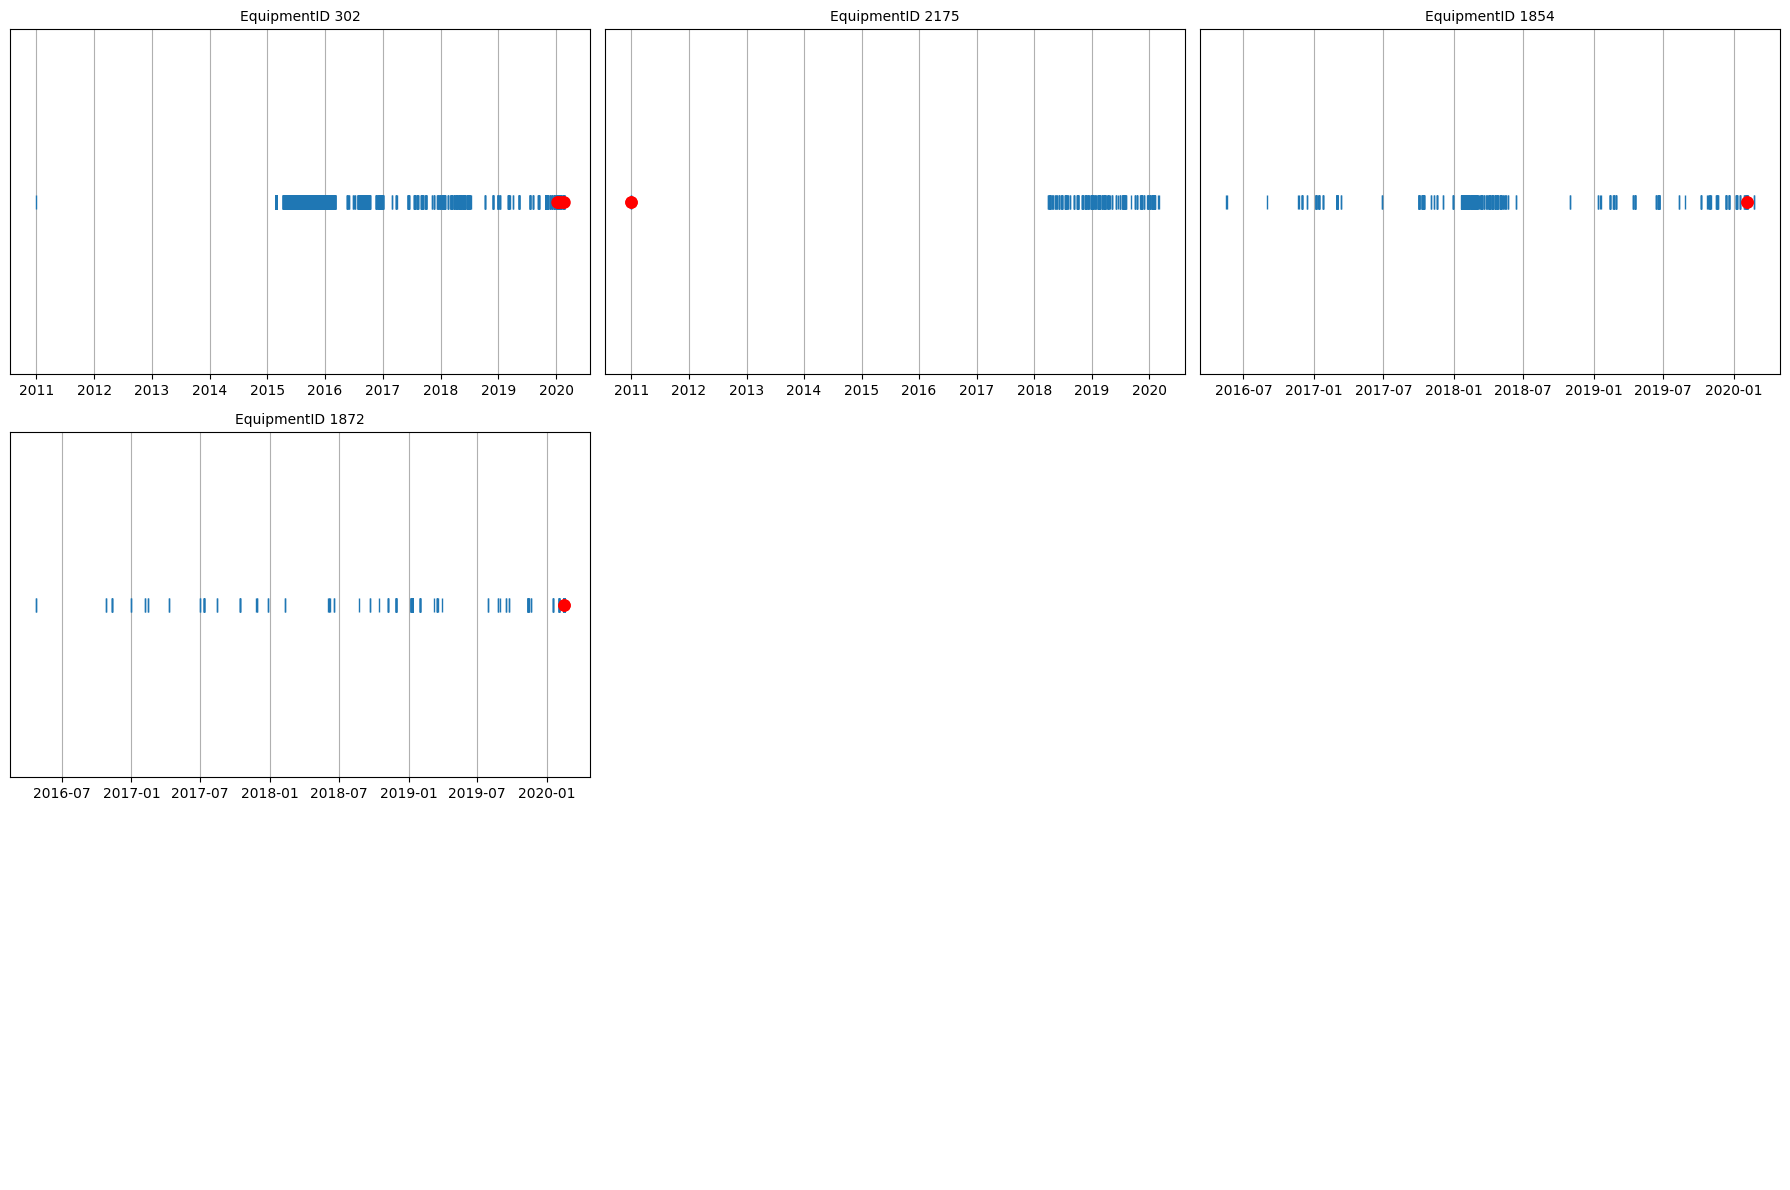

In [36]:
merge['EquipmentID'] = merge['EquipmentID'].astype(str)
merge['EventTimeStamp'] = pd.to_datetime(merge['EventTimeStamp'], errors='coerce')
# Unique Equipment IDs with spn==5246
equipment_ids = [
    '1630', '1487', '1329', '1419', '1486', '1509', '1492', '1473', '1383', '1396', '1431', '1795', '1366', '1339',
    '1391', '1399', '1417', '1591', '1490', '1547', '1444', '1437', '1453', '1692', '1590', '1418', '1472', '1560',
    '1572', '1375', '1742', '1566', '1778', '305', '1659', '1403', '1535', '1524', '1567', '1373', '1665', '1551',
    '1440', '1571', '1443', '1378', '1452', '1488', '1384', '304', '1582', '1508', '1395', '1599', '1501', '1407',
    '1603', '1604', '1477', '1389', '1519', '1757', '1458', '1401', '1579', '1534', '1575', '1539', '1601', '1657',
    '1592', '1563', '1557', '1605', '1581', '301', '1811', '1573', '1668', '1643', '1561', '1549', '1940', '1839',
    '1552', '1637', '1554', '1529', '1686', '1598', '1745', '1525', '1848', '1537', '1521', '1661', '1831', '1528',
    '1595', '1654', '1543', '1812', '1803', '1814', '1556', '1564', '1585', '1602', '1663', '1623', '1800', '1823',
    '1818', '1586', '2009', '1946', '1749', '1746', '1559', '1711', '1600', '1584', '1939', '1704', '1808', '1743',
    '1822', '1739', '1764', '1846', '2007', '1669', '1819', '105427203', '1780', '2143', '1718', '2111', '1874',
    '1689', '1932', '1794', '1978', '1691', '105349576', '1942', '1928', '1921', '1860', '1877', '1878', '306',
    '1853', '1748', '1758', '1919', '1958', '1683', '2209', '1847', '1815', '2082', '1698', '1827', '1857', '1918',
    '1751', '1961', '1985', '1828', '1964', '1768', '1834', '1970', '1896', '2109', '1797', '1951', '1945', '1864',
    '2004', '1858', '1922', '1991', '2021', '1907', '1947', '2089', '2211', '302', '2175', '1854', '1872'
]
plots_per_page = 9 
for page in range(-(-len(equipment_ids) // plots_per_page)):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    for idx, ax in enumerate(axes.flatten()):
        i = page * plots_per_page + idx
        if i >= len(equipment_ids):
            ax.axis('off')
            continue
        df = merge.loc[merge['EquipmentID'] == equipment_ids[i]].sort_values('EventTimeStamp')
        if df.empty:
            ax.axis('off')
            continue
        ax.plot(df['EventTimeStamp'], [1]*len(df), '|', markersize=10)
        ax.plot(df.loc[df['spn'] == 5246, 'EventTimeStamp'], [1]*df['spn'].eq(5246).sum(), 'ro', markersize=8)
        ax.set_title(f'EquipmentID {equipment_ids[i]}', fontsize=10)
        ax.set_yticks([])
        ax.grid(True)
    plt.tight_layout()
    plt.show()